# Taxi Rides Time Forecasting

The project goal is to create a predictive model to forecast the number of taxi rides that will happen in Manhattan (New York City):
- in the next hour
- for each taxi zone (e.g. Zone 113 "Lower Manhattan")

The data was retrieved from [here](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

### Load the Workspace

In [1]:
import re
import datetime as dt
import warnings
import random
import time
import humanize
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

from tqdm import notebook
from tqdm import tqdm
tqdm.pandas()
from itertools import product
from typing import Union, Optional, Tuple, Sequence, Callable, cast

import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
import requests_cache
# from openmeteo_requests import openmeteo_requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from geopy.geocoders import Nominatim

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveMean, NaiveDrift, ExponentialSmoothing, AutoARIMA, ARIMA, Theta, FFT, NaiveMovingAverage
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mase, mse, mae, ope, mape
from darts.metrics.metrics import _get_values_or_raise
from darts.metrics import metrics as dart_metrics
from hmmlearn import hmm
from pykalman import KalmanFilter
from bsts import bsts

from sklearn.preprocessing import StandardScaler

/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/plotly_resampler/aggregation/aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


### Load the Dataset

- The data dictionary for the Yellow taxi trip records is [here](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).
- The data dictionary for the Green taxi trip records is [here](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf).
- The data dictionary for the for-hire vehicle trip records is [here](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_fhv.pdf).
- The data dictionary for taxi zones is [here](https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv).

In [2]:
yellow_jan23 = pd.read_parquet('yellow_tripdata_2023-01.parquet').assign(taxi_type='yellow')
green_jan23  = pd.read_parquet('green_tripdata_2023-01.parquet').assign(taxi_type='green')

yellow_jan22 = pd.read_parquet('yellow_tripdata_2022-01.parquet').assign(taxi_type='yellow')
green_jan22  = pd.read_parquet('green_tripdata_2022-01.parquet').assign(taxi_type='green')

yellow_dec22 = pd.read_parquet('yellow_tripdata_2022-12.parquet').assign(taxi_type='yellow')
green_dec22  = pd.read_parquet('green_tripdata_2022-12.parquet').assign(taxi_type='green')

taxi_zones = pd.read_csv('taxi+_zone_lookup.csv')

**Merge Datasets**

In [3]:
yellow = pd.concat([yellow_jan22, yellow_dec22, yellow_jan23], axis=0)
green = pd.concat([green_jan22, green_dec22, green_jan23], axis=0).drop(columns=['ehail_fee', 'trip_type'])

yellow = yellow.rename(columns={'tpep_pickup_datetime': 'pickup_datetime', 'tpep_dropoff_datetime': 'dropoff_datetime'})
green = green.rename(columns={'lpep_pickup_datetime': 'pickup_datetime', 'lpep_dropoff_datetime': 'dropoff_datetime'})

df = pd.concat([yellow, green], axis=0, ignore_index=True)
df.head()

VendorID     pickup_datetime    dropoff_datetime  passenger_count  \
0         1 2022-01-01 00:35:40 2022-01-01 00:53:29              2.0   
1         1 2022-01-01 00:33:43 2022-01-01 00:42:07              1.0   
2         2 2022-01-01 00:53:21 2022-01-01 01:02:19              1.0   
3         2 2022-01-01 00:25:21 2022-01-01 00:35:23              1.0   
4         2 2022-01-01 00:36:48 2022-01-01 01:14:20              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           3.80         1.0                  N           142           236   
1           2.10         1.0                  N           236            42   
2           0.97         1.0                  N           166           166   
3           1.09         1.0                  N           114            68   
4           4.30         1.0                  N            68           163   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           1.0         14.5    3.0      0.5        3.65           0.0   
1           1.0          8.0    0.5      0.5        4.00           0.0   
2           1.0          7.5    0.5      0.5        1.76           0.0   
3           2.0          8.0    0.5      0.5        0.00           0.0   
4           1.0         23.5    0.5      0.5        3.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    0.3         21.95                   2.5          0.0   
1                    0.3         13.30                   0.0          0.0   
2                    0.3         10.56                   0.0          0.0   
3                    0.3         11.80                   2.5          0.0   
4                    0.3         30.30                   2.5          0.0   

  taxi_type  
0    yellow  
1    yellow  
2    yellow  
3    yellow  
4    yellow

In [4]:
df['VendorID'] = df.VendorID.astype('category')
df['RatecodeID'] = df.RatecodeID.astype('category')
df['store_and_fwd_flag'] = df.store_and_fwd_flag.astype('category')
df['payment_type'] = df.payment_type.astype('category')
df['taxi_type'] = df.taxi_type.astype('category')
df['PULocationID'] = df['PULocationID'].astype('category')
df['DOLocationID'] = df['DOLocationID'].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9133391 entries, 0 to 9133390
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   pickup_datetime        datetime64[us]
 2   dropoff_datetime       datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           category      
 8   DOLocationID           category      
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

**Clear Memory**

In [6]:
del yellow, yellow_jan23, yellow_dec22, yellow_jan22, green, green_jan23, green_dec22, green_jan22

### Data Cleaning
**Handling Missing Data**

In [7]:
print(f'NUMBER OF MISSING VALUES IN DATASET: \n')
display(df.isnull().sum().sort_values(ascending=False))
n_rows, n_cols = df.shape[0], df.shape[1]
n_cells = (n_rows * n_cols)
n_missing = df.isnull().sum().sum()

print(f"Missing value percentage in dataset {round((n_missing / n_cells) * 100, 3)}%")

NUMBER OF MISSING VALUES IN DATASET: 


airport_fee              472854
passenger_count          287403
congestion_surcharge     287403
RatecodeID               287403
store_and_fwd_flag       287403
payment_type              17694
VendorID                      0
mta_tax                       0
total_amount                  0
improvement_surcharge         0
tolls_amount                  0
tip_amount                    0
fare_amount                   0
extra                         0
pickup_datetime               0
DOLocationID                  0
PULocationID                  0
trip_distance                 0
dropoff_datetime              0
taxi_type                     0
dtype: int64

Missing value percentage in dataset 0.898%


In [8]:
def handle_missing_data(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0 and df[col].dtype not in [int, float]:
            df[col] = df[col].fillna(df[col].mode()[0])
        elif df[col].isnull().sum() > 0 and df[col].dtype in [int, float]:
            df[col] = df[col].fillna(df[col].mean())
        else:
            pass
    
    return df

df = handle_missing_data(df)

print(f'NUMBER OF MISSING VALUES IN DATASET: \n')
display(df.isnull().sum().sort_values(ascending=False))
n_rows, n_cols = df.shape[0], df.shape[1]
n_cells = (n_rows * n_cols)
n_missing = df.isnull().sum().sum()

print(f"Missing value percentage in dataset {round((n_missing / n_cells) * 100, 3)}%")

NUMBER OF MISSING VALUES IN DATASET: 


VendorID                 0
pickup_datetime          0
airport_fee              0
congestion_surcharge     0
total_amount             0
improvement_surcharge    0
tolls_amount             0
tip_amount               0
mta_tax                  0
extra                    0
fare_amount              0
payment_type             0
DOLocationID             0
PULocationID             0
store_and_fwd_flag       0
RatecodeID               0
trip_distance            0
passenger_count          0
dropoff_datetime         0
taxi_type                0
dtype: int64

Missing value percentage in dataset 0.0%


**Remove Absurd or Irregular Values**

In [9]:
df.shape

(9133391, 20)

In [10]:
def handle_irregular_values(df):
    # Remove any values outside the dates that have been selected (Jan 2022, December 2022 & Jan 2023)
    df = df.drop(index=df.loc[(df.pickup_datetime.dt.year <= 2021) | (df.dropoff_datetime.dt.year <= 2021)].index)
    
    # Remove Unknown Location IDs
    df = df.drop(index=df.loc[(df.PULocationID.isin([264, 265])) | (df.DOLocationID.isin([264, 265]))].index)
    
    return df

df = handle_irregular_values(df)
df.shape

(8954767, 20)

**Create New Variables**

In [11]:
df['trip_length'] = df.dropoff_datetime - df.pickup_datetime

### Data Transformation

We'll transform the raw data into (features, targets) and train-test split in 4 sub-steps:
- Validate the raw data
- Aggregate raw data into time-series
- Transform time-series into (features, target)
- Train-test split


**Determine Target Variable**

We need to group trips by pick up location ID and sum up all trips from the location. The sum value will be our target variable.

In [12]:
tt = df.groupby(['PULocationID', 'taxi_type'], observed=False).resample('h', on='pickup_datetime').size().reset_index().set_index('pickup_datetime').sort_index()
tt = tt.rename(columns={0:'total_trips'})
tt.head()

PULocationID taxi_type  total_trips
pickup_datetime                                    
2022-01-01                79    yellow          226
2022-01-01                42    yellow            3
2022-01-01                43     green            1
2022-01-01               170    yellow          185
2022-01-01                43    yellow           97

In [13]:
tt.shape

(4442333, 3)

**Average Values Per Hour for Other Relevant Variables**

In [14]:
avg_df = df.groupby(['PULocationID', 'taxi_type'], observed=False).resample('h', on='pickup_datetime').mean(numeric_only=True).reset_index().set_index('pickup_datetime').sort_index()
avg_df.head()

PULocationID taxi_type  passenger_count  trip_distance  \
pickup_datetime                                                          
2022-01-01                79    yellow         1.774854       2.420796   
2022-01-01                42    yellow         1.666667       1.836667   
2022-01-01                43     green         1.000000       0.000000   
2022-01-01               170    yellow         1.765181       2.506595   
2022-01-01                43    yellow         1.896907       2.150722   

                 fare_amount     extra   mta_tax  tip_amount  tolls_amount  \
pickup_datetime                                                              
2022-01-01         11.734204  1.088496  0.488938    2.457389      0.028982   
2022-01-01          8.333333  0.500000  0.500000    0.653333      0.000000   
2022-01-01          8.000000  0.500000  0.500000    0.000000      0.000000   
2022-01-01         10.940216  1.275676  0.491892    2.112919      0.212432   
2022-01-01          9.865979  0.979381  0.489691    2.082577      0.030928   

                 improvement_surcharge  total_amount  congestion_surcharge  \
pickup_datetime                                                              
2022-01-01                    0.297345     17.964823              2.468770   
2022-01-01                    0.300000     10.286667              0.000000   
2022-01-01                    0.300000     12.050000              2.750000   
2022-01-01                    0.296757     16.992054              2.453898   
2022-01-01                    0.293814     15.675361              2.422680   

                 airport_fee  
pickup_datetime               
2022-01-01          0.003534  
2022-01-01          0.000000  
2022-01-01          0.099826  
2022-01-01          0.002158  
2022-01-01          0.000000

In [15]:
avg_df.shape

(4442333, 13)

In [16]:
def mode_by_hour(group):
    return group.mode().iloc[0] if not group.empty else pd.NA

In [17]:
# cat_df = (df.set_index('pickup_datetime')
#           .select_dtypes(include='category')
#           .groupby(['PULocationID', 'taxi_type'], observed=False)
#           .resample('h')
#           .apply(mode_by_hour)
#           .drop(columns=['PULocationID', 'taxi_type'])
#           .reset_index(level=['PULocationID', 'taxi_type'])
#           .sort_index())
# 
# cat_df.head()

In [18]:
# cat_df.reset_index().to_csv('cat_df.csv', index=False)
cat_df = pd.read_csv('cat_df.csv', parse_dates=True, low_memory=False).assign(pickup_datetime=lambda x: pd.to_datetime(x.pickup_datetime))
cat_df.head()

pickup_datetime  PULocationID taxi_type  VendorID  RatecodeID  \
0      2022-01-01            79    yellow       2.0         1.0   
1      2022-01-01            42    yellow       2.0         1.0   
2      2022-01-01            43     green       2.0         1.0   
3      2022-01-01           170    yellow       2.0         1.0   
4      2022-01-01            43    yellow       2.0         1.0   

  store_and_fwd_flag  DOLocationID  payment_type  
0                  N          79.0           1.0  
1                  N          74.0           2.0  
2                  N         163.0           2.0  
3                  N          79.0           1.0  
4                  N         162.0           1.0

In [19]:
cat_df.shape

(4442333, 8)

**Obtain Additional Information**

We'd like to obtain information such weather conditions, day of the week and special events.

In [20]:
taxi_zones.head()

LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone

In [21]:
# def set_geolocator(locations):
#     # Initialize the geolocator
#     geolocator = Nominatim(user_agent="axis_key")
#     
#     # Define empty lists to store longitude and latitude
#     longitudes = []
#     latitudes = []
#     
#     # Loop through locations and find longitude and latitude for each
#     for location in locations:
#         location_data = geolocator.geocode(location)
#         if location_data:
#             longitudes.append(location_data.longitude)
#             latitudes.append(location_data.latitude)
#         else:
#             longitudes.append(None)
#             latitudes.append(None)
#     
#     # Create a DataFrame to store the data
#     data = {
#         'PULocationID': taxi_zones.LocationID,
#         'location': locations,
#         'longitude': longitudes,
#         'latitude': latitudes,
#     }
#     loc_df = pd.DataFrame(data)
#     
#     return loc_df
# 
# # Define a list of locations
# locations = taxi_zones.Zone + ', ' + taxi_zones.Borough
# loc_df = set_geolocator(locations)

# cat_df = cat_df.reset_index().merge(loc_df, on=['PULocationID'], how='left')
# cat_df.shape

In [22]:
# loc_df.to_csv('locations_coordinates.csv', index=False)
loc_df = pd.read_csv('locations_coordinates.csv')
cat_df = cat_df.reset_index().merge(loc_df, on=['PULocationID'], how='left')
cat_df.shape

(4442333, 12)

In [23]:
cat_df = cat_df.drop(columns=['index'])
cat_df.head()

pickup_datetime  PULocationID taxi_type  VendorID  RatecodeID  \
0      2022-01-01            79    yellow       2.0         1.0   
1      2022-01-01            42    yellow       2.0         1.0   
2      2022-01-01            43     green       2.0         1.0   
3      2022-01-01           170    yellow       2.0         1.0   
4      2022-01-01            43    yellow       2.0         1.0   

  store_and_fwd_flag  DOLocationID  payment_type  \
0                  N          79.0           1.0   
1                  N          74.0           2.0   
2                  N         163.0           2.0   
3                  N          79.0           1.0   
4                  N         162.0           1.0   

                          location  longitude   latitude  
0          East Village, Manhattan -73.987361  40.729269  
1  Central Harlem North, Manhattan        NaN        NaN  
2          Central Park, Manhattan -73.965363  40.782773  
3           Murray Hill, Manhattan -73.978750  40.748157  
4          Central Park, Manhattan -73.965363  40.782773

In [24]:
longitudes = loc_df.dropna().longitude.tolist()
latitudes = loc_df.dropna().latitude.tolist()

indices_to_remove = [44, 116]  # Example indices to remove

# Remove values at specified indices
long_filt = [value for index, value in enumerate(longitudes) if index not in indices_to_remove]
lat_filt = [value for index, value in enumerate(latitudes) if index not in indices_to_remove]

In [25]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

responses = list()
for i in range(len(long_filt)):
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    long = long_filt[i]
    lat = lat_filt[i]
    params = {
        "latitude": lat,
        "longitude": long,
        "start_date": "2022-01-01",
        "end_date": "2023-01-31",
        "hourly": ["temperature_2m", "precipitation"]
    }
    response = openmeteo.weather_api(url, params=params)
    responses.append(response)

Parse Weather Data:

In [26]:
len(long_filt), len(responses)

(195, 195)

In [27]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly_data_list = list()
for ind, i in enumerate(responses):
    response = i[0]
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
         
    hourly_data = {
        "latitude": [latitudes[ind] for j in hourly_temperature_2m],
        "longitude": [longitudes[ind] for j in hourly_temperature_2m],
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ), 
        "temperature_2m": hourly_temperature_2m, 
        "precipitation": hourly_precipitation, 
    }
        
    hourly_data_list.append(hourly_data)

In [28]:
hourly_df = []

# Iterate over each dictionary in the list
for d in hourly_data_list:
    # Convert the dictionary to a DataFrame
    df_temp = pd.DataFrame(d)
    # Append the DataFrame to the list
    hourly_df.append(df_temp)

print(len(hourly_df))
hourly_df = pd.concat(hourly_df, ignore_index=True)
# hourly_df = hourly_df.set_index('date')
print(hourly_df.shape)

195
(1853280, 5)


In [29]:
hourly_df.longitude.unique().shape

(193,)

Compare hourly df values and filtered location values:

In [30]:
for ind, i in enumerate(responses):
    try:
        print(ind)
        print('Locations: ', lat_filt[ind], long_filt[ind])
        print('Hourly: ', hourly_df.latitude.unique()[ind], hourly_df.longitude.unique()[ind])
        print('Category: ', cat_df.latitude.dropna().unique()[ind], cat_df.longitude.dropna().unique()[ind])
    except IndexError as e:
        print(e)
        continue

0
Locations:  40.68906405 -74.17725485035348
Hourly:  40.68906405 -74.17725485035348
Category:  40.7292688 -73.9873613
1
Locations:  40.6039936 -73.8354124
Hourly:  40.6039936 -73.8354124
Category:  40.7827725 -73.9653627406542
2
Locations:  40.7251022 -73.9795833
Hourly:  40.7251022 -73.9795833
Category:  40.7481574 -73.97875
3
Locations:  40.563699850000006 -74.1916031653169
Hourly:  40.563699850000006 -74.1916031653169
Category:  40.807837000000006 -73.90642492860718
4
Locations:  40.6032168 -74.0665662
Hourly:  40.6032168 -74.0665662
Category:  40.81 -73.9625
5
Locations:  40.7720145 -73.9302673
Hourly:  40.7720145 -73.9302673
Category:  40.7164913 -73.9962504
6
Locations:  40.7788277 -73.92265804019786
Hourly:  40.7788277 -73.92265804019786
Category:  40.7498417 -73.984251
7
Locations:  40.7614516 -73.7897239
Hourly:  40.7614516 -73.7897239
Category:  40.7649371 -73.9850825
8
Locations:  40.67592055 -73.78496487588887
Hourly:  40.67592055 -73.78496487588887
Category:  40.7598219 -

Find which values are omitted from the final dataframe:

In [31]:
print(long_filt[-2:], lat_filt[-2:])
display(loc_df.iloc[-4:])

[-73.9535563, -119.7325651] [40.7770447, 39.2115779]


PULocationID                   location   longitude   latitude
261           262  Yorkville East, Manhattan  -73.953556  40.777045
262           263  Yorkville West, Manhattan         NaN        NaN
263           264                NV, Unknown -119.732565  39.211578
264           265                        NaN   11.048029  46.314475

Add PULocationID to hourly_df:

In [32]:
hourly_df.head()

latitude  longitude                      date  temperature_2m  \
0  40.689064 -74.177255 2022-01-01 00:00:00+00:00        8.773499   
1  40.689064 -74.177255 2022-01-01 01:00:00+00:00        9.573500   
2  40.689064 -74.177255 2022-01-01 02:00:00+00:00        8.773499   
3  40.689064 -74.177255 2022-01-01 03:00:00+00:00        8.473500   
4  40.689064 -74.177255 2022-01-01 04:00:00+00:00        7.373500   

   precipitation  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [33]:
loc_map = loc_df[['latitude', 'longitude', 'PULocationID']].iloc[:-4].dropna().set_index(['latitude', 'longitude']).to_dict()['PULocationID']

hourly_df['PULocationID'] = hourly_df.apply(lambda row: loc_map.get((row['latitude'], row['longitude']), None), axis=1)

# Prepare Date feature for merging with cat_df
hourly_df = hourly_df.assign(date=lambda x: x.date.dt.tz_localize(None).astype('datetime64[ns]'))
hourly_df = hourly_df.rename(columns={'date':'pickup_datetime'})

display(hourly_df.head())
display(cat_df.head())

latitude  longitude     pickup_datetime  temperature_2m  precipitation  \
0  40.689064 -74.177255 2022-01-01 00:00:00        8.773499            0.0   
1  40.689064 -74.177255 2022-01-01 01:00:00        9.573500            0.0   
2  40.689064 -74.177255 2022-01-01 02:00:00        8.773499            0.0   
3  40.689064 -74.177255 2022-01-01 03:00:00        8.473500            0.0   
4  40.689064 -74.177255 2022-01-01 04:00:00        7.373500            0.0   

   PULocationID  
0             1  
1             1  
2             1  
3             1  
4             1

pickup_datetime  PULocationID taxi_type  VendorID  RatecodeID  \
0      2022-01-01            79    yellow       2.0         1.0   
1      2022-01-01            42    yellow       2.0         1.0   
2      2022-01-01            43     green       2.0         1.0   
3      2022-01-01           170    yellow       2.0         1.0   
4      2022-01-01            43    yellow       2.0         1.0   

  store_and_fwd_flag  DOLocationID  payment_type  \
0                  N          79.0           1.0   
1                  N          74.0           2.0   
2                  N         163.0           2.0   
3                  N          79.0           1.0   
4                  N         162.0           1.0   

                          location  longitude   latitude  
0          East Village, Manhattan -73.987361  40.729269  
1  Central Harlem North, Manhattan        NaN        NaN  
2          Central Park, Manhattan -73.965363  40.782773  
3           Murray Hill, Manhattan -73.978750  40.748157  
4          Central Park, Manhattan -73.965363  40.782773

In [34]:
display(cat_df.info(), hourly_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442333 entries, 0 to 4442332
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_datetime     datetime64[ns]
 1   PULocationID        int64         
 2   taxi_type           object        
 3   VendorID            float64       
 4   RatecodeID          float64       
 5   store_and_fwd_flag  object        
 6   DOLocationID        float64       
 7   payment_type        float64       
 8   location            object        
 9   longitude           float64       
 10  latitude            float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 372.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853280 entries, 0 to 1853279
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   latitude         float64       
 1   longitude        float64       
 2   pickup_datetime  da

None

None

In [35]:
cat_df = pd.merge(cat_df, hourly_df, on=['PULocationID', 'pickup_datetime', 'longitude', 'latitude'], how='left', suffixes=('_cat', '_hr'))

**Merge Aggregated Dfs**

In [36]:
df2 = tt.reset_index().merge(avg_df.reset_index(), on=['PULocationID', 'taxi_type', 'pickup_datetime'], suffixes=['_tt', '_avg']).merge(cat_df, on=['PULocationID', 'taxi_type', 'pickup_datetime'], suffixes=['_ttavg', '_cat'])

df2 = df2[~df2.pickup_datetime.dt.month.isin(list(range(2, 12)))].set_index('pickup_datetime')

df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017659 entries, 2022-01-01 00:00:00 to 2023-01-31 23:00:00
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PULocationID           1017659 non-null  int64  
 1   taxi_type              1017659 non-null  object 
 2   total_trips            1017659 non-null  int64  
 3   passenger_count        270540 non-null   float64
 4   trip_distance          270540 non-null   float64
 5   fare_amount            270540 non-null   float64
 6   extra                  270540 non-null   float64
 7   mta_tax                270540 non-null   float64
 8   tip_amount             270540 non-null   float64
 9   tolls_amount           270540 non-null   float64
 10  improvement_surcharge  270540 non-null   float64
 11  total_amount           270540 non-null   float64
 12  congestion_surcharge   270540 non-null   float64
 13  airport_fee            270540 non-null 

In [37]:
df2.index.month.unique(), df2.index.year.unique()

(Index([1, 12], dtype='int32', name='pickup_datetime'),
 Index([2022, 2023], dtype='int32', name='pickup_datetime'))

In [38]:
df2 = df2.rename(columns={
    'PULocationID': 'pickup_location', 
    'DOLocationID': 'dropoff_location', 
    'temperature_2m': 'temperature',
    'VendorID': 'vendor',
    'RatecodeID': 'rate_code'
})

In [39]:
df2.columns

Index(['pickup_location', 'taxi_type', 'total_trips', 'passenger_count',
       'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'airport_fee', 'vendor', 'rate_code',
       'store_and_fwd_flag', 'dropoff_location', 'payment_type', 'location',
       'longitude', 'latitude', 'temperature', 'precipitation'],
      dtype='object')

Free up Space:

In [40]:
del hourly_data_list, hourly_data, hourly_precipitation, hourly_temperature_2m, latitudes, longitudes, lat, long, loc_df, tt, avg_df, cat_df, responses, response, lat_filt, long_filt, d, df_temp, hourly_df, hourly, indices_to_remove, loc_map

### Visualize Data

In [41]:
deep_colors = [
    '#2e921b', '#7f1b92', '#4C72B0', '#55A868',
    '#C44E52', '#8172B2', '#CCB974', '#64B5CD'
]

In [42]:
yellow = df2.loc[df2.taxi_type=='yellow']
green = df2.loc[df2.taxi_type=='green']

Generally yellow taxi has more total trips than green taxi:

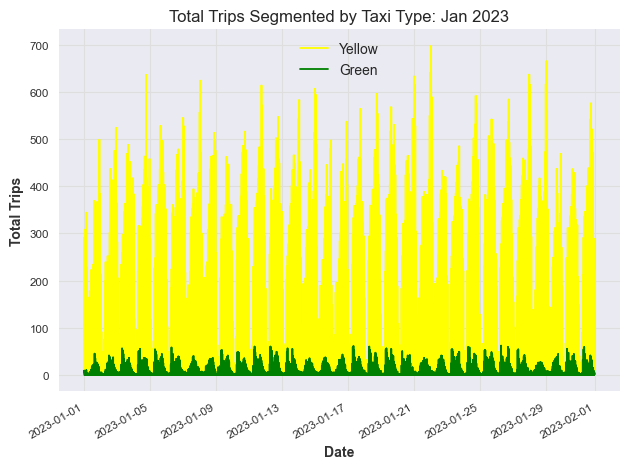

In [43]:
fig, ax = plt.subplots()

ax.plot(yellow.loc[yellow.index.year==2023].total_trips, color='yellow', label='Yellow')
ax.plot(green.loc[green.index.year==2023].total_trips, color='green', label='Green')
ax.set_xlabel('Date')
ax.set_ylabel('Total Trips')
ax.set_title('Total Trips Segmented by Taxi Type: Jan 2023')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

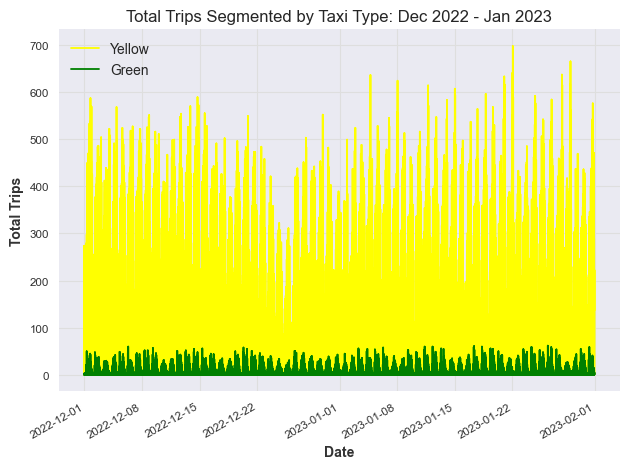

In [44]:
fig, ax = plt.subplots()

comparison_date = pd.Timestamp('2022-11-01')
ax.plot(yellow.loc[yellow.index >= comparison_date].total_trips, color='yellow', label='Yellow')
ax.plot(green.loc[green.index >= comparison_date].total_trips, color='green', label='Green')
ax.set_xlabel('Date')
ax.set_ylabel('Total Trips')
ax.set_title('Total Trips Segmented by Taxi Type: Dec 2022 - Jan 2023')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

When January 2022 & January 2023 are compared, yellow taxis have seen an increase in total trips year-on-year over the period.

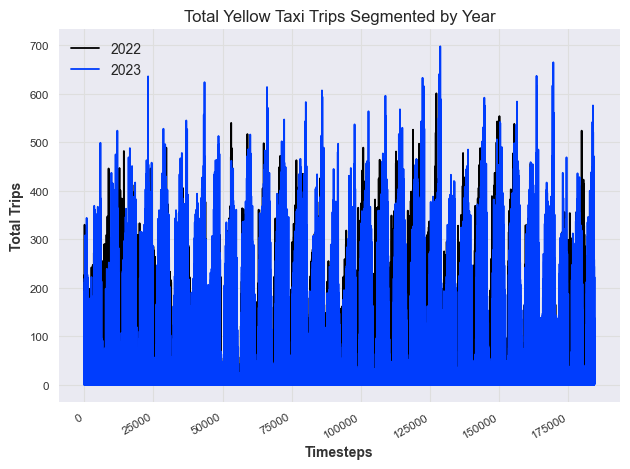

In [45]:
fig, ax = plt.subplots()

comparison_date = pd.Timestamp('2022-11-01')
ax.plot(range(yellow.loc[(yellow.index.year==2022) & (yellow.index.month==1)].shape[0]), yellow.loc[(yellow.index.year==2022) & (yellow.index.month==1)].total_trips,label='2022')
ax.plot(range(yellow.loc[yellow.index.year==2023].shape[0]), yellow.loc[yellow.index.year==2023].total_trips, label='2023')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Total Trips')
ax.set_title('Total Yellow Taxi Trips Segmented by Year')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

To allow us to better predict total trips, we'll drill down into the most popular locations for taxi trips:

Select top 5 Highest Locations for Different Taxis

In [46]:
yellow_top_5_locs = yellow.groupby('pickup_location').sum().sort_values(by='total_trips', ascending=False).index[:5]
print(yellow_top_5_locs)

green_top_5_locs = green.groupby('pickup_location').sum().sort_values(by='total_trips', ascending=False).index[:5]
print('\n', green_top_5_locs)

Index([237, 132, 236, 161, 142], dtype='int64', name='pickup_location')

 Index([74, 75, 41, 166, 95], dtype='int64', name='pickup_location')


In [47]:
yellow_132 = yellow.loc[yellow.pickup_location == yellow_top_5_locs[1], 'total_trips'].asfreq('h')

green_74 = yellow.loc[yellow.pickup_location == green_top_5_locs[0], 'total_trips'].asfreq('h')

In [48]:
df = pd.merge(
    yellow_132, green_74, how='left', 
    left_index=True, right_index=True, 
    suffixes=('_y132', '_g74')
).fillna(value=0)
df['hour'] = df.index.hour

df = df.rename(columns={'total_trips_y132':'yellow_132',
                        'total_trips_g74':'green_74'})

# Remove records for months that are not January and December
df = df[~df.index.month.isin(list(range(2, 12)))]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2232 entries, 2022-01-01 00:00:00 to 2023-01-31 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yellow_132  2232 non-null   float64
 1   green_74    2232 non-null   float64
 2   hour        2232 non-null   int32  
dtypes: float64(2), int32(1)
memory usage: 61.0 KB


### Yellow 132 - Forecasting

**Distribution of Total Trips**

In [49]:
def plot_hist_box(data, column):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    sns.histplot(data=data, x=column, bins=20, kde=True, ax=ax1, color='#2c921b')
    sns.boxplot(data=data, x=column, ax=ax2, color='#921b8b')
    ax1.set_title(f"Histogram and Box Plot of {column}", size=15, weight='bold')
    ax1.set_xlabel(column, size=12, weight='bold')
    ax1.set_ylabel("Frequency", size=12, weight='bold')
    ax2.set_xlabel(column, size=12, weight='bold')
    ax2.set_ylabel("Value", size=12, weight='bold')
    plt.show()

There is a significant number of hours with total trips under 25. This represents the spike at the beginning of our histogram. This contributes to a right-skewed distribution.

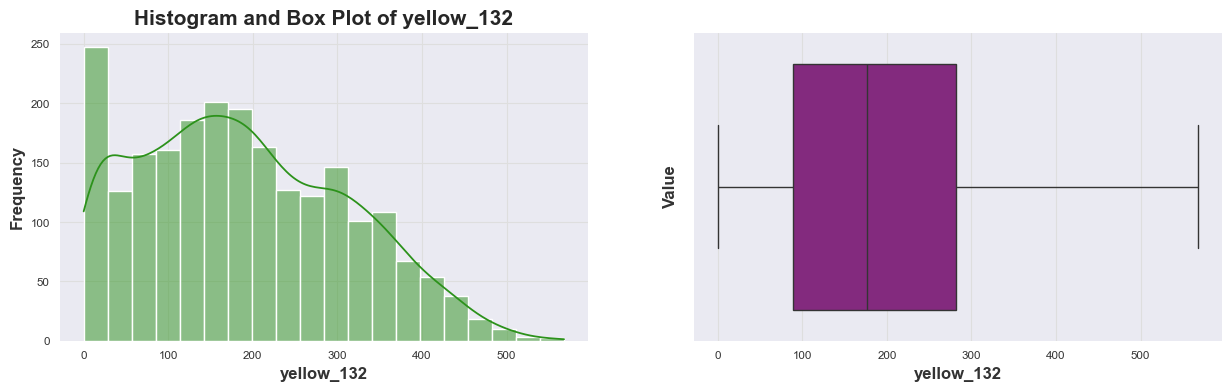

In [50]:
plot_hist_box(df, 'yellow_132')

In [51]:
df.loc[df.yellow_132 < 25].shape

(226, 3)

**Visualization**

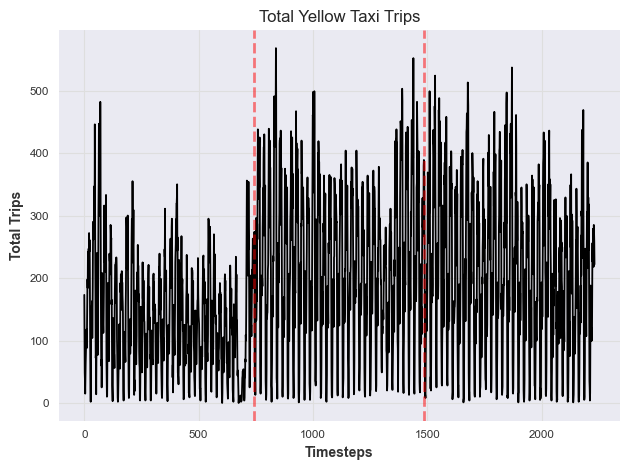

In [52]:
fig, ax = plt.subplots()

ax.plot(range(df.shape[0]), df.yellow_132)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Total Trips')
ax.set_title('Total Yellow Taxi Trips')

j22_last_day = df.loc[(df.index.month == 1) & (df.index.year==2022)].index.argmax()
d22_last_day = df.loc[(df.index.month == 12) & (df.index.year==2022)].index.argmax()*2
plt.axvline(j22_last_day, color='red', linestyle='--', alpha=0.5, linewidth=2)
plt.axvline(d22_last_day, color='red', linestyle='--', alpha=0.5, linewidth=2)

# fig.autofmt_xdate()
plt.tight_layout()
plt.show()

There has been a significant year-on-year increase in total trips between January 2022 and January 2023, however, when plotted against December 2022, any increase in January 2023 is muted and not clearly visible, implying a linear increase month on month.

We'll test this statistically.

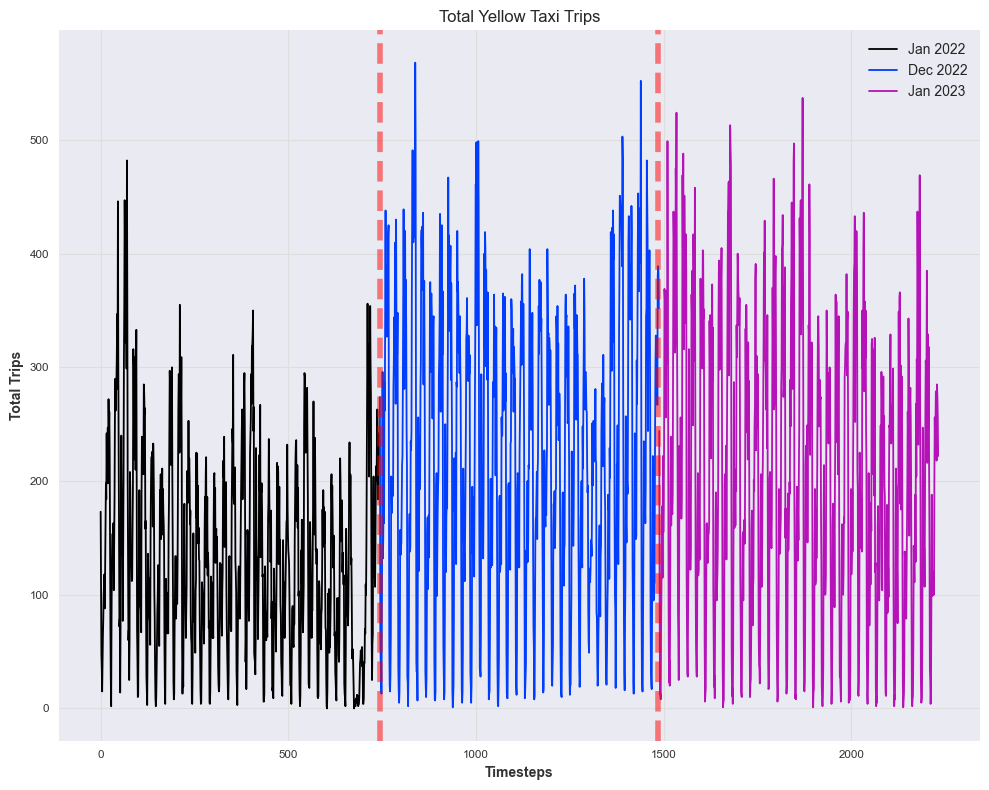

In [53]:
j22 = df.loc[(df.index.month == 1) & (df.index.year==2022)]
j23 = df.loc[(df.index.month == 1) & (df.index.year==2023)]
d22 = df.loc[(df.index.month == 12) & (df.index.year==2022)]
temp_df = pd.concat([j22, d22, j23], axis=0).reset_index()

plt.figure(figsize=(10, 8))
plt.plot(temp_df.loc[temp_df.pickup_datetime.isin(j22.index)].index, j22.yellow_132, label='Jan 2022')
plt.plot(temp_df.loc[temp_df.pickup_datetime.isin(d22.index)].index, d22.yellow_132, label='Dec 2022')
plt.plot(temp_df.loc[temp_df.pickup_datetime.isin(j23.index)].index, j23.yellow_132, label='Jan 2023')

# Demarcate Months with Vertical Line
j22_last_day = j22.index.argmax()
d22_last_day = d22.index.argmax()*2
plt.axvline(j22_last_day, color='red', linestyle='--', alpha=0.5, linewidth=4)
plt.axvline(d22_last_day, color='red', linestyle='--', alpha=0.5, linewidth=4)

# Adding labels and title
plt.xlabel('Timesteps')
plt.ylabel('Total Trips')
plt.title('Total Yellow Taxi Trips')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

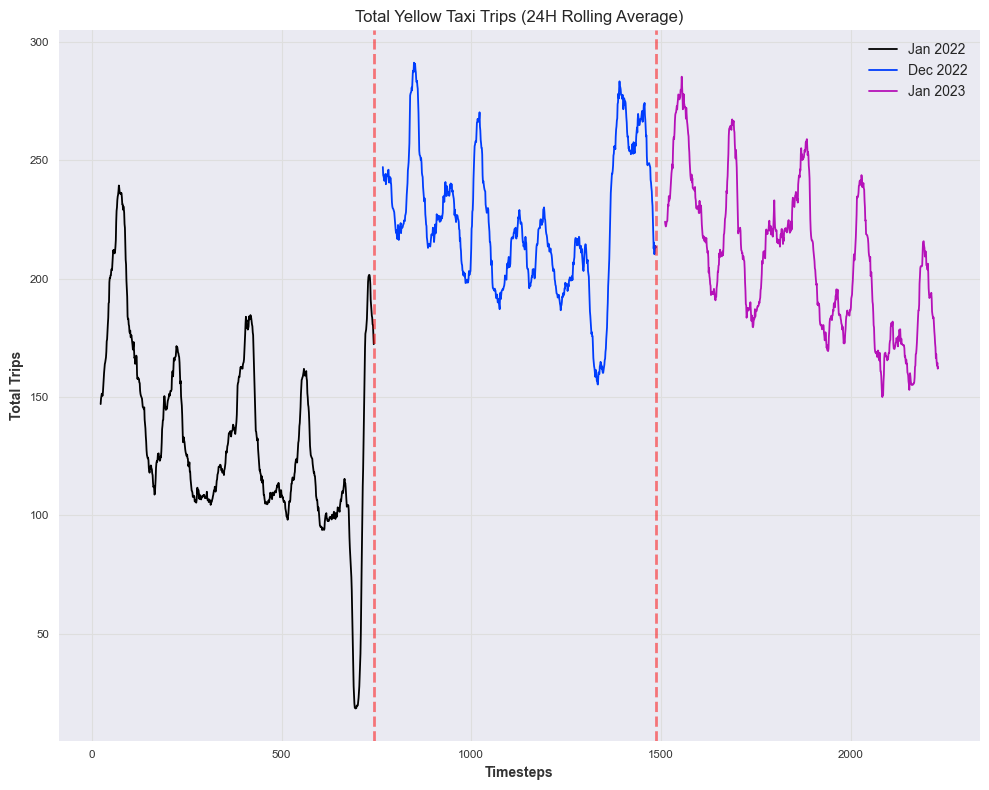

In [54]:
j22 = df.loc[(df.index.month == 1) & (df.index.year==2022)].rolling(24).mean()
j23 = df.loc[(df.index.month == 1) & (df.index.year==2023)].rolling(24).mean()
d22 = df.loc[(df.index.month == 12) & (df.index.year==2022)].rolling(24).mean()
temp_df = pd.concat([j22, d22, j23], axis=0).reset_index()

plt.figure(figsize=(10, 8))
plt.plot(temp_df.loc[temp_df.pickup_datetime.isin(j22.index)].index, j22.yellow_132, label='Jan 2022')
plt.plot(temp_df.loc[temp_df.pickup_datetime.isin(d22.index)].index, d22.yellow_132, label='Dec 2022')
plt.plot(temp_df.loc[temp_df.pickup_datetime.isin(j23.index)].index, j23.yellow_132, label='Jan 2023')

# Demarcate Months with Vertical Line
j22_last_day = j22.index.argmax()
d22_last_day = d22.index.argmax()*2
plt.axvline(j22_last_day, color='red', linestyle='--', alpha=0.5, linewidth=2)
plt.axvline(d22_last_day, color='red', linestyle='--', alpha=0.5, linewidth=2)

# Adding labels and title
plt.xlabel('Timesteps')
plt.ylabel('Total Trips')
plt.title('Total Yellow Taxi Trips (24H Rolling Average)')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

Using Correlation Analysis to Determine whether date is related to any changes in total trips for yellow 132, we find that hour is most correlated with total trips and the correlation is positive:

In [55]:
data = df.assign(
    hour=lambda x: x.index.hour,
    day=lambda x: x.index.day,
    month=lambda x: x.index.month,
    year=lambda x: x.index.year
)[['hour', 'day', 'month', 'year', 'yellow_132']].corr()

def style_correlation(val):
    # Highest correlation that is not 1
    if 0.4 <= abs(val) <= 0.9 and abs(val)==[x for x in sorted(abs(data.values.flatten())) if x <1][-1]:
        return 'background-color: green'
    # Lowest correlation that is not 0
    elif 0.1 <= abs(val) <= 0.3 and abs(val)==[x for x in sorted(abs(data.values.flatten())) if x >.01][0]:
        return 'background-color: red'
    else:
        return ''


display(data.style.map(style_correlation, subset=['yellow_132']))

In [56]:
del temp_df, j22, j23, d22, data

Determining Whether Weather is Related to Total Trips:

In [57]:
y132_w = yellow.loc[(yellow.pickup_location == yellow_top_5_locs[1]) & (yellow.index.year==2023), ['total_trips', 'temperature', 'precipitation']].asfreq('h')
y132_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2023-01-01 00:00:00 to 2023-01-31 23:00:00
Freq: h
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_trips    744 non-null    int64  
 1   temperature    744 non-null    float32
 2   precipitation  744 non-null    float32
dtypes: float32(2), int64(1)
memory usage: 17.4 KB


In [58]:
fig, ax1 = plt.subplots()

# Plot the first feature on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trips', color=color)
ax1.plot(y132_w.index, y132_w['total_trips'], color=color, label='Total Trips')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Create a secondary y-axis for the second and third features
ax2 = ax1.twinx()

# Plot the second feature on the secondary y-axis
color = 'tab:red'
ax2.set_ylabel('Weather', color=color)
ax2.plot(y132_w.index, y132_w['temperature'], color=color, label='Temperature')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Plot the third feature on the secondary y-axis
color = 'tab:green'
ax2.plot(y132_w.index, y132_w['precipitation'], color=color, label='Precipitation')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Adjust layout
plt.suptitle('Yellow 132 Plot')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


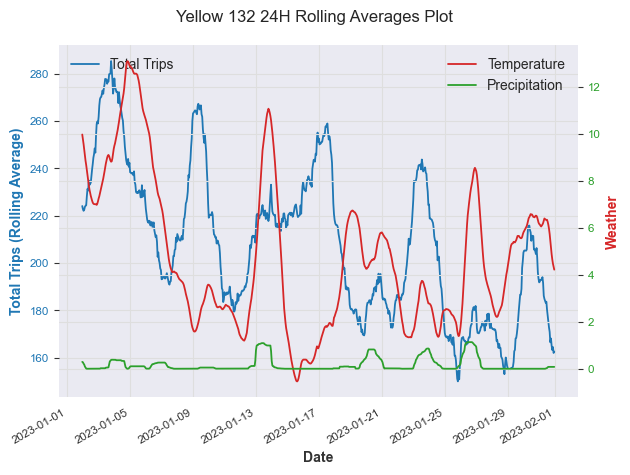

In [59]:
# Calculate rolling averages
rolling_window = 24 

y132_w_rolling = y132_w.rolling(window=rolling_window).mean()

# Create the plot
fig, ax1 = plt.subplots()

# Plot the rolling average of the first feature on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trips (Rolling Average)', color=color)
ax1.plot(y132_w_rolling.index, y132_w_rolling['total_trips'], color=color, label='Total Trips')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Create a secondary y-axis for the second and third features
ax2 = ax1.twinx()

# Plot the rolling average of the second feature on the secondary y-axis
color = 'tab:red'
ax2.set_ylabel('Weather', color=color)
ax2.plot(y132_w_rolling.index, y132_w_rolling['temperature'], color=color, label='Temperature')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Plot the rolling average of the third feature on the secondary y-axis
color = 'tab:green'
ax2.plot(y132_w_rolling.index, y132_w_rolling['precipitation'], color=color, label='Precipitation')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Adjust layout
plt.suptitle('Yellow 132 24H Rolling Averages Plot')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


When we compare the line plot of Yellow 132 total trips to temperature and precipitation for the period and location, trends are not clear. However, when we compare their 24H moving average, we find that spikes in total trips precede spikes in temperature. We'll also test this relationship using correlation:

In [60]:
data = y132_w[['temperature', 'precipitation', 'total_trips']].corr()

display(data.style.format())

In [61]:
yj22 = df.loc[(df.index.year==2022) & (df.index.month==1), 'yellow_132']
yd22 = df.loc[(df.index.year==2022) & (df.index.month==12), 'yellow_132']
yj23 = df.loc[(df.index.year==2023) & (df.index.month==1), 'yellow_132']

fig, ax = plt.subplots()

ax.plot(range(yj22.shape[0]), yj22, label='Jan 2022')
ax.plot(range(yd22.shape[0]), yd22, label='Dec 2022')
ax.plot(range(yj23.shape[0]), yj23, label='Jan 2023')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Total Trips')
ax.legend()

# Adjust layout
plt.suptitle('Yellow 132 Plot')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

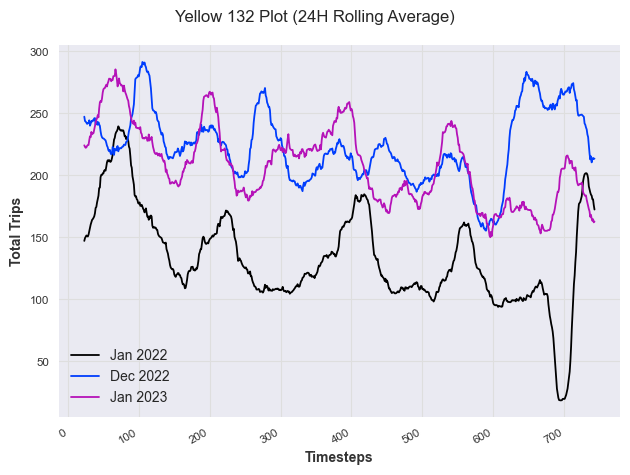

In [62]:
yj22 = df.loc[(df.index.year==2022) & (df.index.month==1), 'yellow_132'].rolling(24).mean()
yd22 = df.loc[(df.index.year==2022) & (df.index.month==12), 'yellow_132'].rolling(24).mean()
yj23 = df.loc[(df.index.year==2023) & (df.index.month==1), 'yellow_132'].rolling(24).mean()

fig, ax = plt.subplots()

ax.plot(range(yj22.shape[0]), yj22, label='Jan 2022')
ax.plot(range(yd22.shape[0]), yd22, label='Dec 2022')
ax.plot(range(yj23.shape[0]), yj23, label='Jan 2023')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Total Trips')
ax.legend()

# Adjust layout
plt.suptitle('Yellow 132 Plot (24H Rolling Average)')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [63]:
yj22 = df.loc[(df.index.year==2022) & (df.index.month==1), 'yellow_132'].reset_index(drop=True)
yd22 = df.loc[(df.index.year==2022) & (df.index.month==12), 'yellow_132'].reset_index(drop=True)
yj23 = df.loc[(df.index.year==2023) & (df.index.month==1), 'yellow_132'].reset_index(drop=True)
data = pd.concat([yj22, yd22, yj23], axis=1)
data.columns = ['jan_22', 'dec_22', 'jan_23']
data = data.corr()

display(data.style.format())

In [64]:
del yj22, yd22, yj23, data, y132_w, y132_w_rolling, yellow_132

Let's compare total trips with charges and tolls and distance.

In [65]:
y132_w = yellow.loc[(yellow.pickup_location == yellow_top_5_locs[1]) & (yellow.index.year==2023), ['total_trips', 'trip_distance', 'tolls_amount', 'fare_amount']].asfreq('h')

y132_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2023-01-01 00:00:00 to 2023-01-31 23:00:00
Freq: h
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_trips    744 non-null    int64  
 1   trip_distance  744 non-null    float64
 2   tolls_amount   744 non-null    float64
 3   fare_amount    744 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 29.1 KB


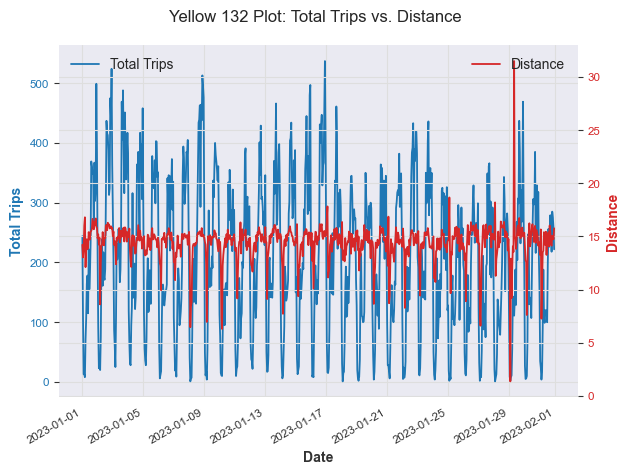

In [66]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trips', color=color)
ax1.plot(y132_w.index, y132_w['total_trips'], color=color, label='Total Trips')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Distance', color=color)
ax2.plot(y132_w.index, y132_w['trip_distance'], color=color, label='Distance')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.suptitle('Yellow 132 Plot: Total Trips vs. Distance')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

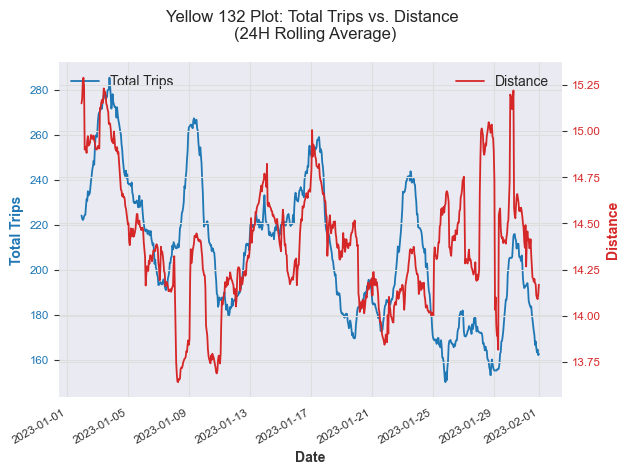

In [67]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trips', color=color)
ax1.plot(y132_w.rolling(24).mean().index, y132_w['total_trips'].rolling(24).mean(), color=color, label='Total Trips')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Distance', color=color)
ax2.plot(y132_w.rolling(24).mean().index, y132_w['trip_distance'].rolling(24).mean(), color=color, label='Distance')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.suptitle('Yellow 132 Plot: Total Trips vs. Distance \n(24H Rolling Average)')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [68]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trips', color=color)
ax1.plot(y132_w.index, y132_w['total_trips'], color=color, label='Total Trips')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Tolls', color=color)
ax2.plot(y132_w.index, y132_w['tolls_amount'], color=color, label='Tolls')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.suptitle('Yellow 132 Plot: Total Trips vs. Tolls')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

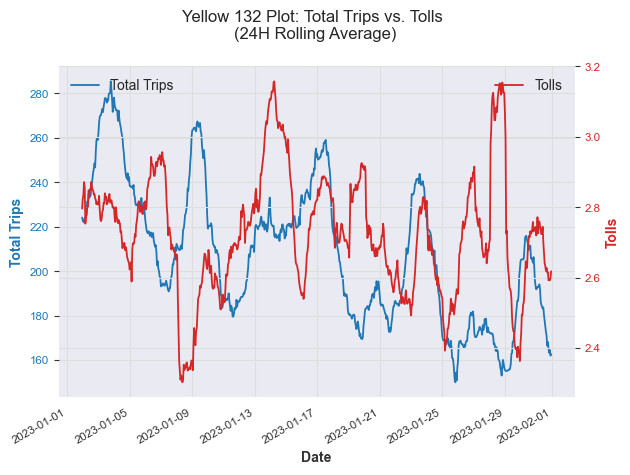

In [69]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trips', color=color)
ax1.plot(y132_w.rolling(24).mean().index, y132_w['total_trips'].rolling(24).mean(), color=color, label='Total Trips')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Tolls', color=color)
ax2.plot(y132_w.rolling(24).mean().index, y132_w['tolls_amount'].rolling(24).mean(), color=color, label='Tolls')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.suptitle('Yellow 132 Plot: Total Trips vs. Tolls \n(24H Rolling Average)')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

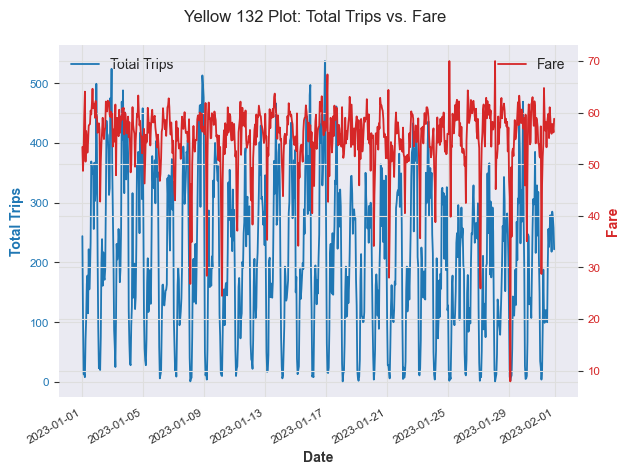

In [70]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trips', color=color)
ax1.plot(y132_w.index, y132_w['total_trips'], color=color, label='Total Trips')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Fare', color=color)
ax2.plot(y132_w.index, y132_w['fare_amount'], color=color, label='Fare')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.suptitle('Yellow 132 Plot: Total Trips vs. Fare')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

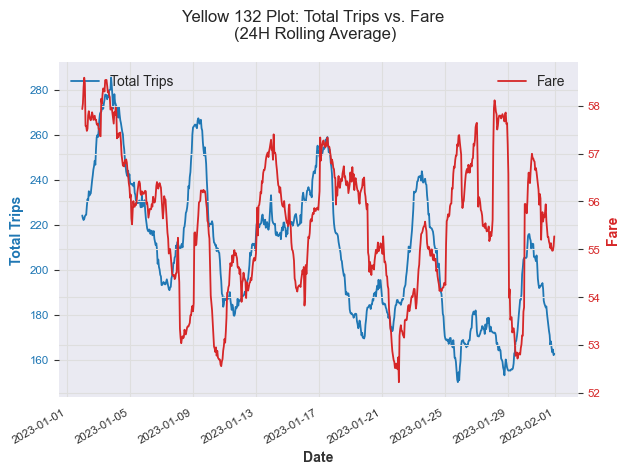

In [71]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Trips', color=color)
ax1.plot(y132_w.rolling(24).mean().index, y132_w['total_trips'].rolling(24).mean(), color=color, label='Total Trips')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Fare', color=color)
ax2.plot(y132_w.rolling(24).mean().index, y132_w['fare_amount'].rolling(24).mean(), color=color, label='Fare')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.suptitle('Yellow 132 Plot: Total Trips vs. Fare \n(24H Rolling Average)')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [72]:
data = y132_w.corr()
display(data.style.format())

In [73]:
del y132_w, data

**Time Series Decomposition**

Below, we decomposed the yellow 132 total trips data by day, week and month. Across all decomposition, we find a downward trend throughout the data of total trips, implying that in our month of interest (January 2023) total trips by yellow taxis within district location id 132 generally declined over time.

The seasonality component implies daily fluctuations, with spikes during evening rush hour. The residuals show no trends, properly capturing random noise in the data.

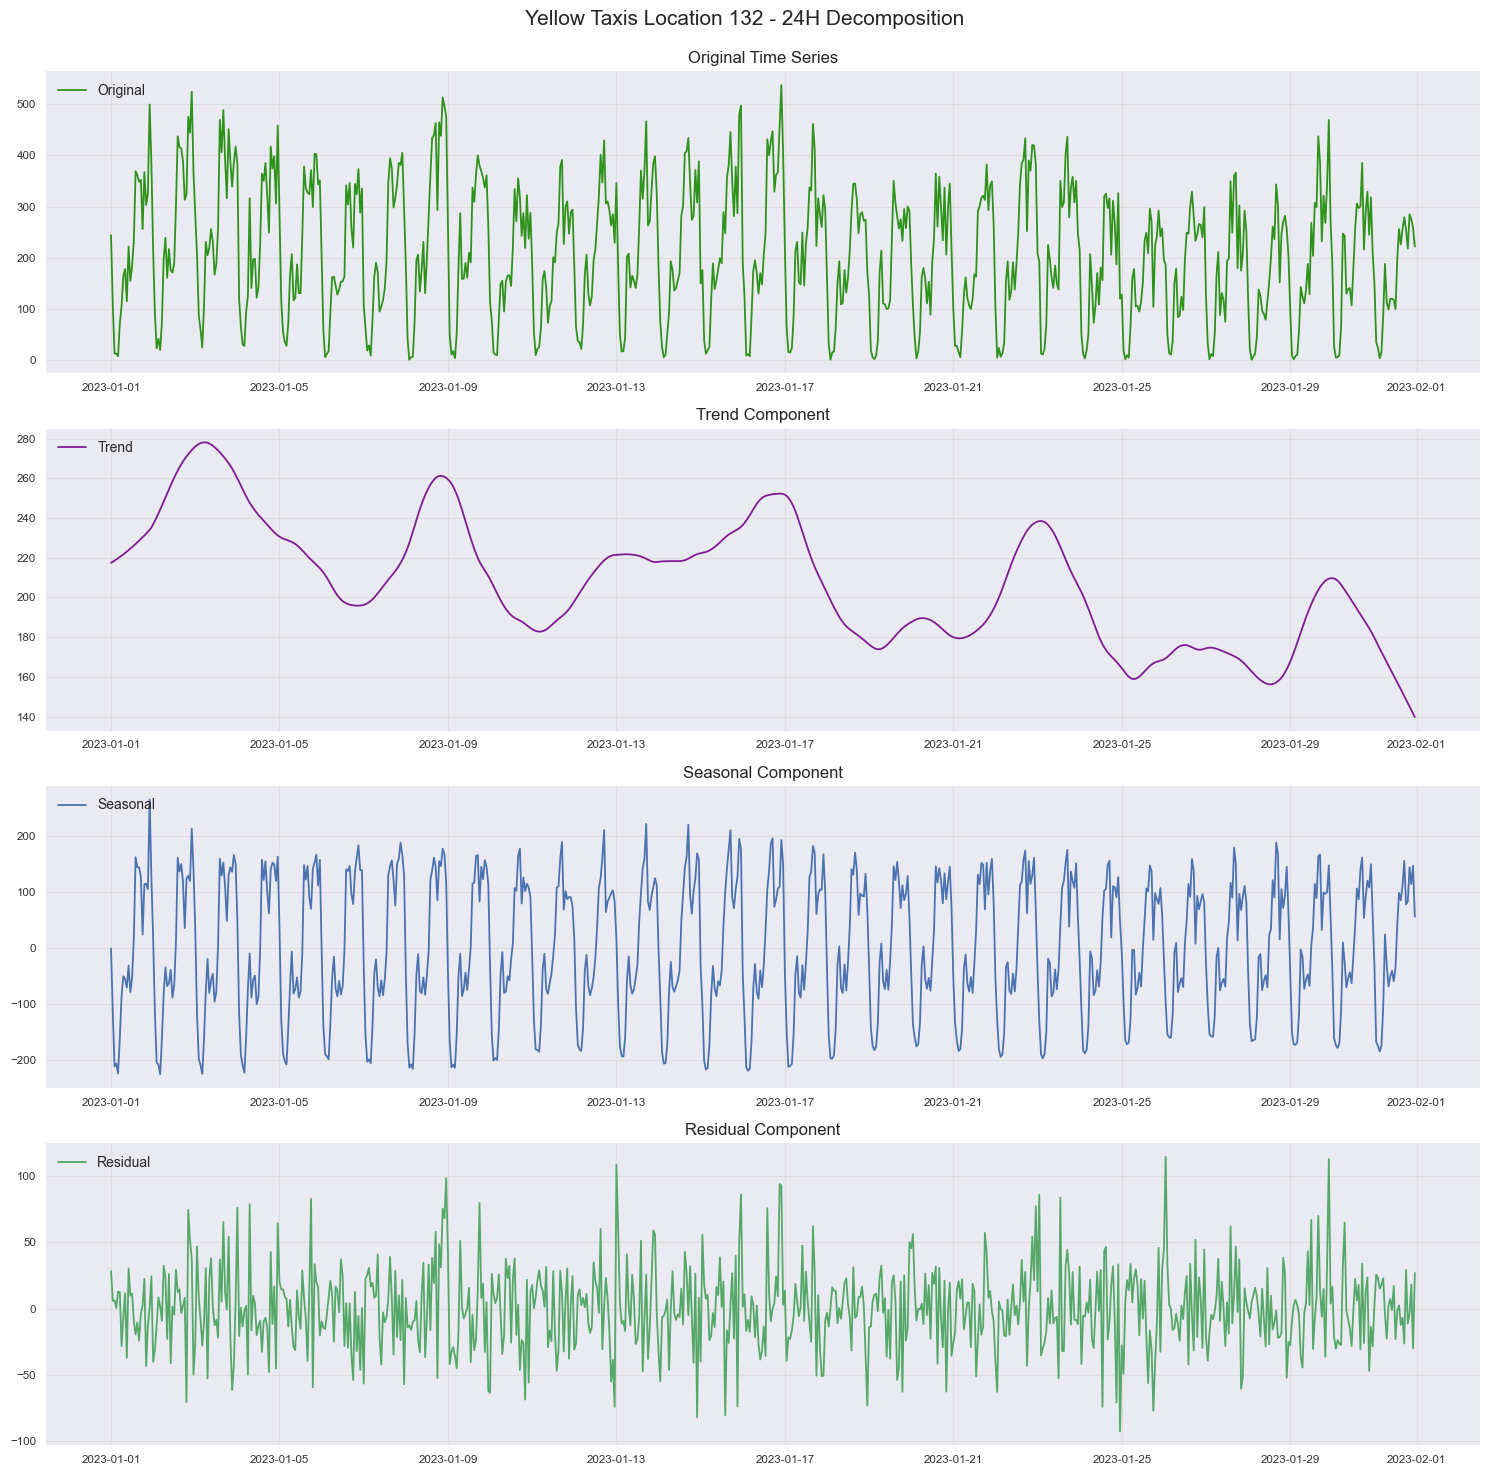

In [74]:
y132_j23 = yellow.loc[(yellow.pickup_location == yellow_top_5_locs[1]) & (yellow.index.year==2023), 'total_trips'].asfreq('h')

decomposition = STL(y132_j23, period=24).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(y132_j23, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.suptitle('Yellow Taxis Location 132 - 24H Decomposition\n', fontsize=15)
plt.tight_layout()
plt.show()

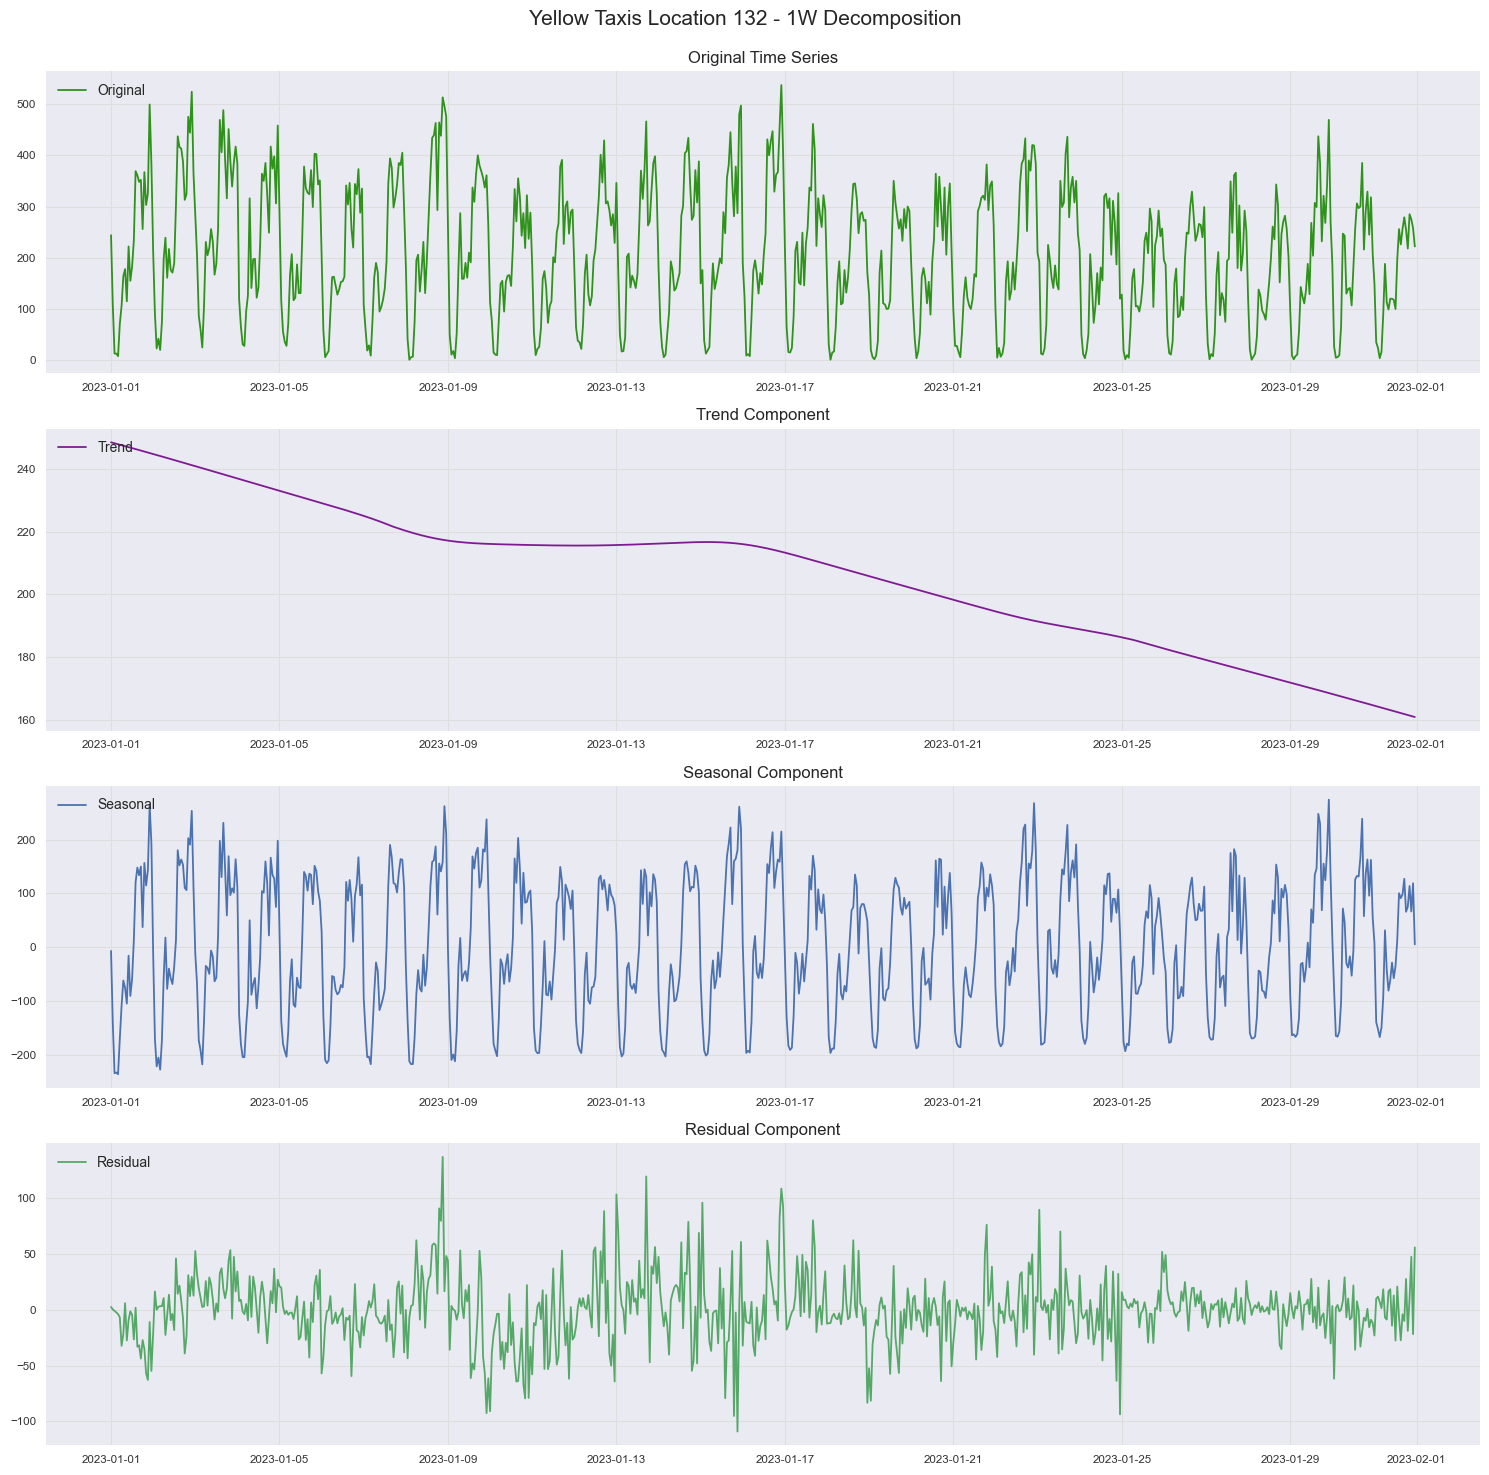

In [75]:
decomposition = STL(y132_j23, period=24*7).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(y132_j23, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.suptitle('Yellow Taxis Location 132 - 1W Decomposition\n', fontsize=15)
plt.tight_layout()
plt.show()

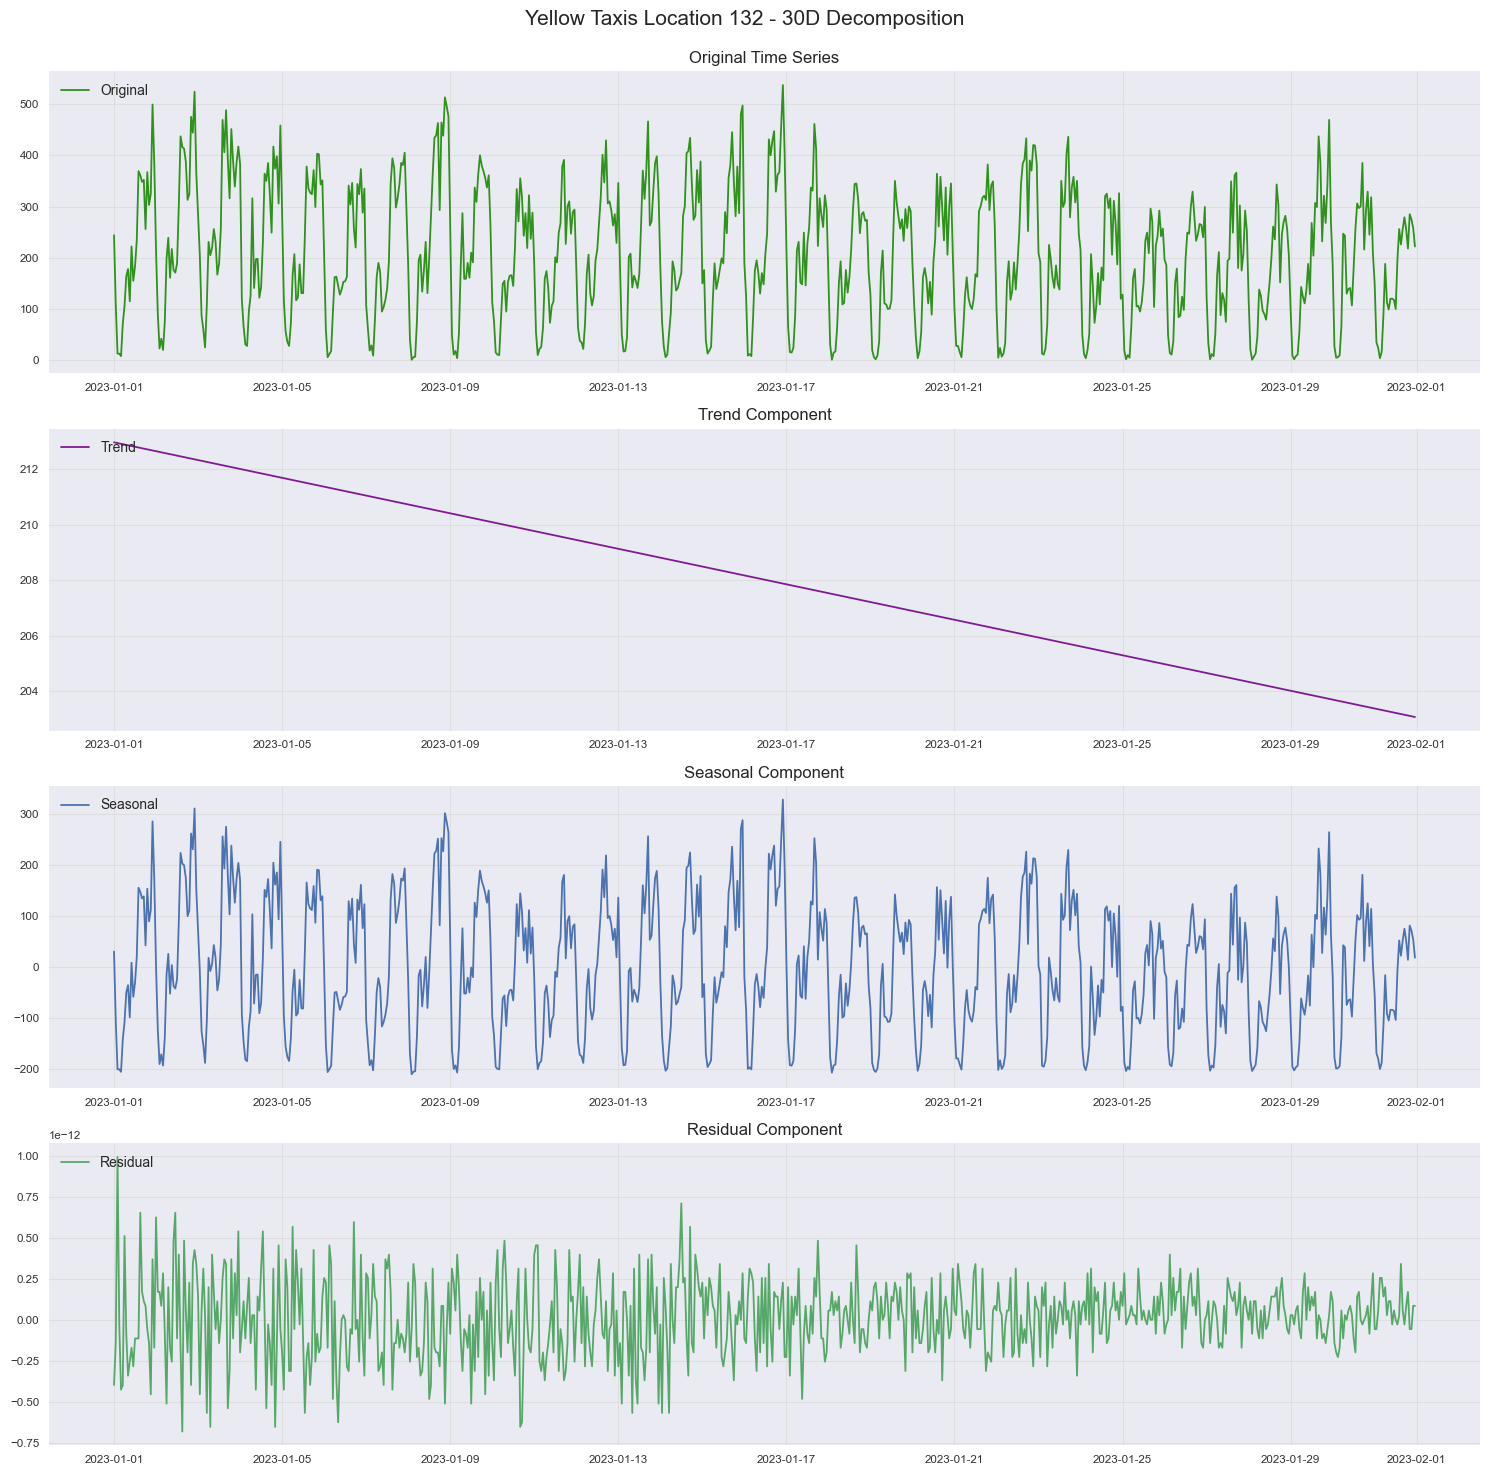

In [76]:
decomposition = STL(y132_j23, period=24*30).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(y132_j23, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.suptitle('Yellow Taxis Location 132 - 30D Decomposition\n', fontsize=15)
plt.tight_layout()
plt.show()

**Train-Test Split**

In [77]:
train, test = y132_j23.loc[y132_j23.index <= pd.to_datetime('2023-01-24')], y132_j23.loc[y132_j23.index > pd.to_datetime('2023-01-24')]

train, val = train.loc[train.index <= pd.to_datetime('2023-01-22')], train.loc[train.index > pd.to_datetime('2023-01-22')]

train.shape, val.shape, test.shape

((505,), (48,), (191,))

**Modelling Yellow 132 Using ARIMA**

The first consideration for an ARIMA model is to determine whether the data is stationary. Stationarity implies that the mean and variance of a time series do not change over time or periodically, i.e., there is no trend, seasonality and heteroscedasticity. Finally, the series requires a unit root, which is decipherable using the Augmented Dickey-Fuller (ADF) test.

For the untransformed/ observed yellow 132 time series, we already know that trend and seasonality exist from our decomposition above. When we apply first order differencing to the data to the make it stationary, we see those trends are removed.

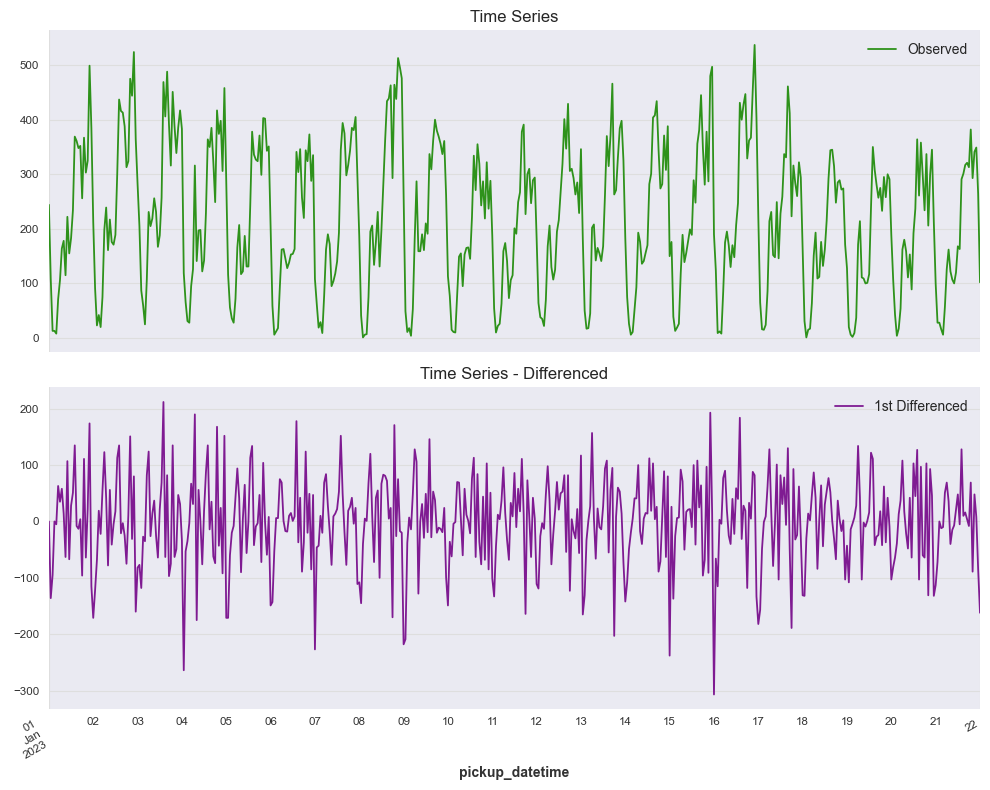

In [78]:
target_diff = train.diff().fillna(0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
train.plot(title='Time Series', ax=ax1, color=deep_colors[0], label='Observed')
target_diff.plot(title='Time Series - Differenced', ax=ax2, color=deep_colors[1], label='1st Differenced')

ax1.legend()
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Decompose the differenced data:

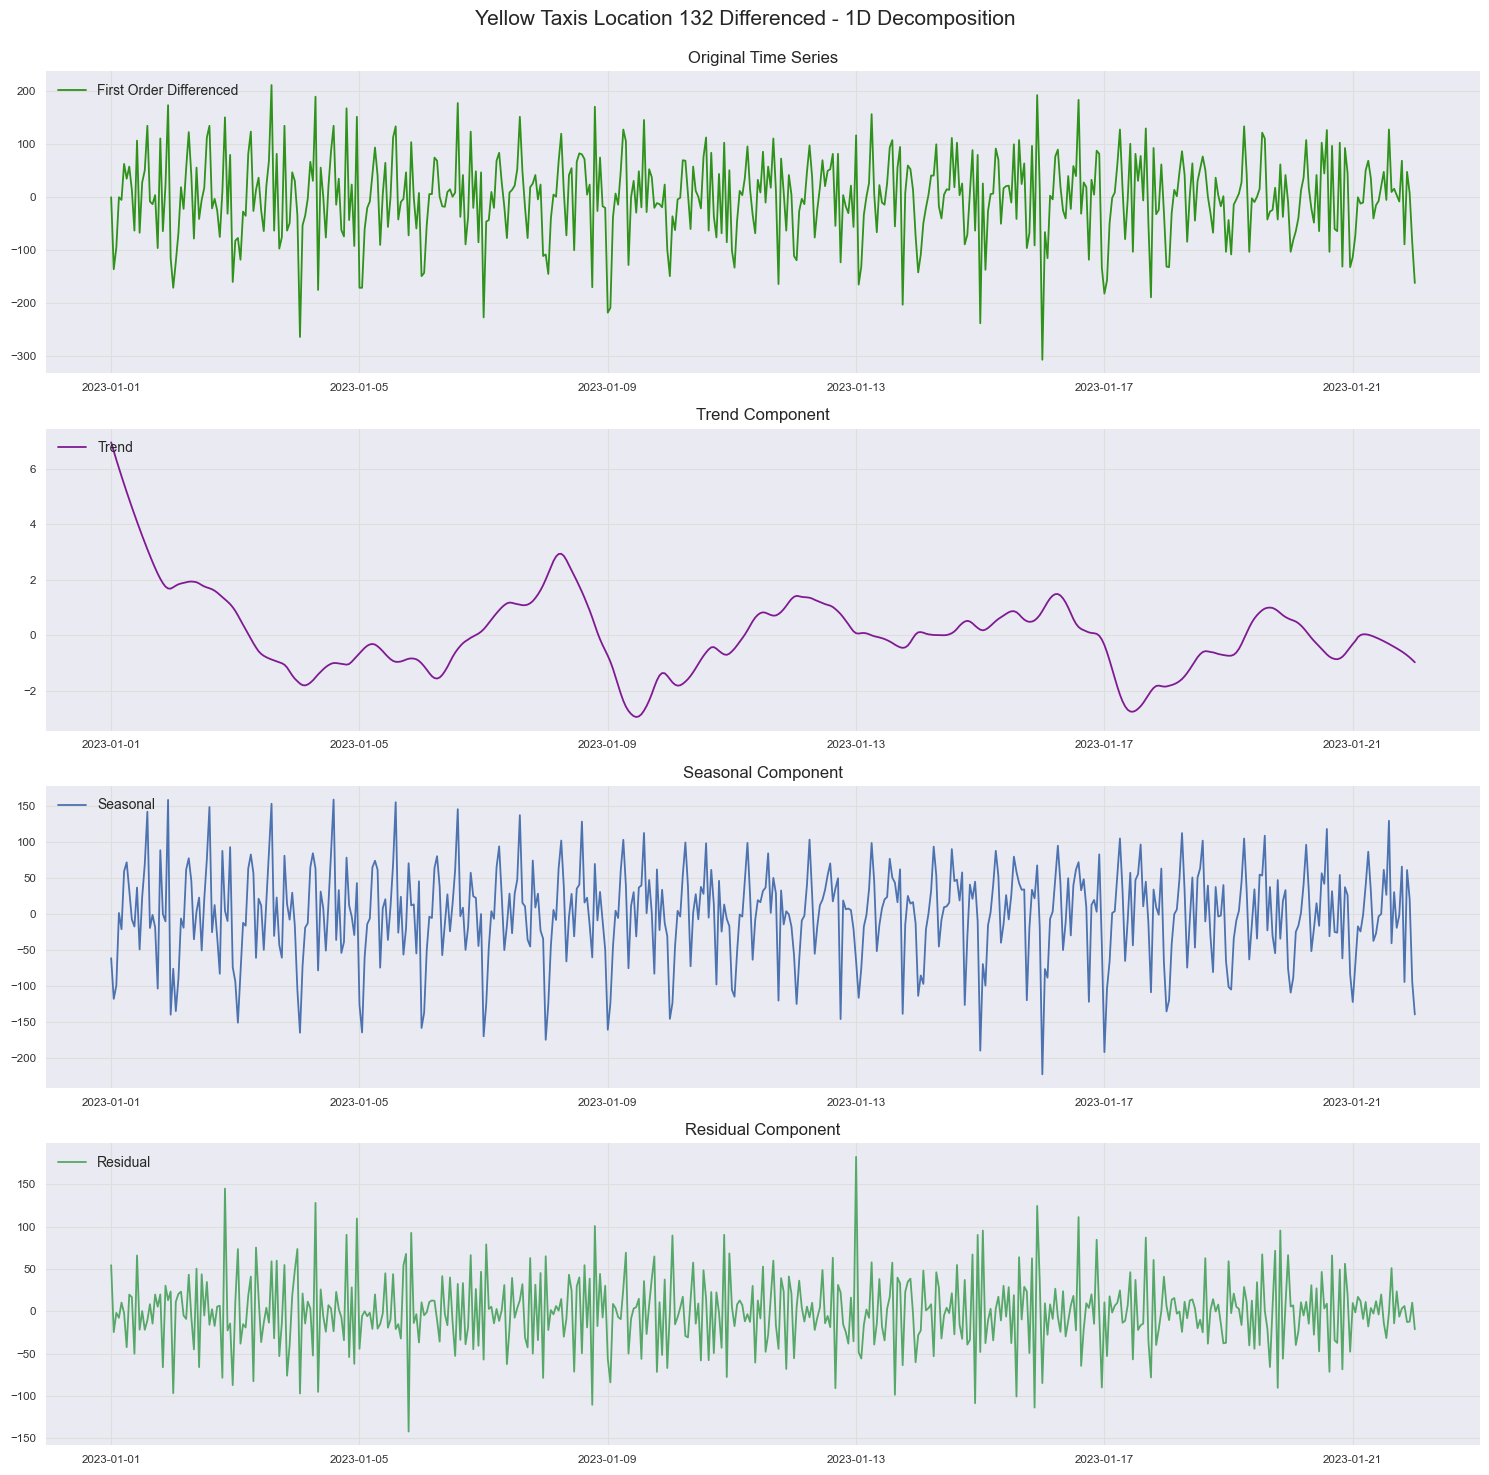

In [79]:
decomposition = STL(target_diff, period=24).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(target_diff, label='First Order Differenced', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.suptitle('Yellow Taxis Location 132 Differenced - 1D Decomposition\n', fontsize=15)
plt.tight_layout()
plt.show()

When we apply the unit root test to both the original and differenced data, the differenced data has a significant higher ADF statistic, even though the original data has a statistically significant unit root. 

In [80]:
ad_fuller_result = adfuller(train)
print('Observed')
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print('\n')
ad_fuller_result = adfuller(target_diff)
print('1st Differenced')
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

Observed
ADF Statistic: -12.867183037538958
p-value: 4.9665206883124354e-24


1st Differenced
ADF Statistic: -13.367506966687541
p-value: 5.2774078491364955e-25


In conclusion, we are better off applying the ARIMA model to the differenced data, which meets all the requirements for stationarity. 

**Deciphering the (p,q) value for the ARIMA model**

In determining the appropriate AR(p) value, we use a visual examination of the PACF plot as well as finding the lag that minimizes the information criterion. In determining the MA(p) value, we'll also visually examine the ACF plot:

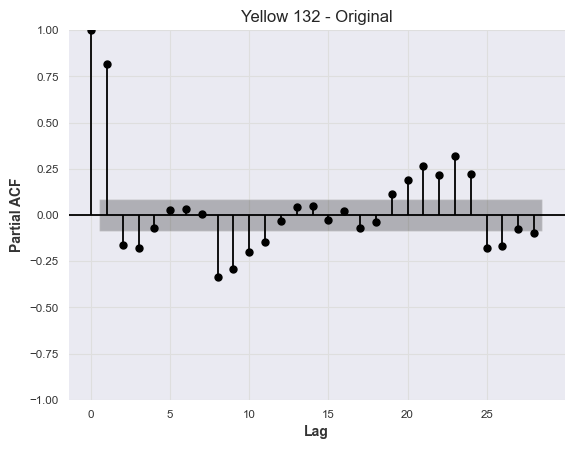

In [81]:
plot_pacf(train, title='Yellow 132 - Original')
plt.xlabel('Lag')
plt.ylabel('Partial ACF')
plt.show()

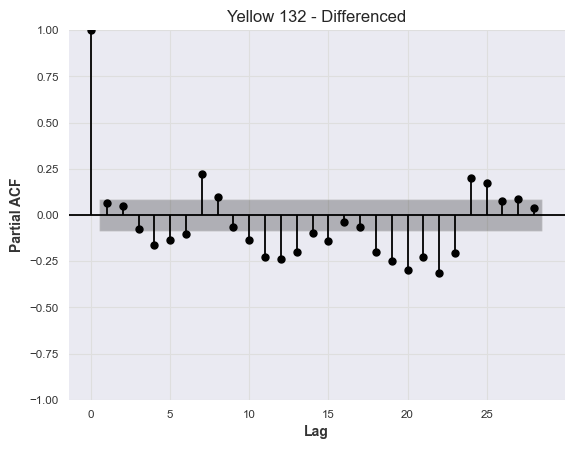

In [82]:
plot_pacf(target_diff, title='Yellow 132 - Differenced')
plt.xlabel('Lag')
plt.ylabel('Partial ACF')
plt.show()

Original AIC:

In [83]:
# Minimizing Information Criterion / Maximum Likelihood Estimation (MLE)
# Initialize variables to store best model and its corresponding AIC
best_aic = float("inf")
best_model = None
best_lag = None

# Define the maximum lag order you want to consider
max_lag = 10

# Iterate over different lag orders
for lag in range(1, max_lag + 1):
    # Fit AR model using maximum likelihood estimation
    model = AutoReg(train, lags=lag).fit()

    # Calculate AIC for the current model
    current_aic = model.aic
    # Update best model if the current AIC is lower
    if current_aic < best_aic:
        best_aic = current_aic
        best_model = model
        best_lag = lag

# Print the best model and its corresponding AIC
print("Best Lag Order:", best_lag)
print("AIC:", best_aic)
print("Coefficients:")
print(best_model.params)

Best Lag Order: 10
AIC: 5540.621609570809
Coefficients:
const              116.390688
total_trips.L1       0.747182
total_trips.L2       0.104833
total_trips.L3      -0.035606
total_trips.L4      -0.141356
total_trips.L5      -0.093356
total_trips.L6      -0.035023
total_trips.L7       0.305129
total_trips.L8      -0.046282
total_trips.L9      -0.133566
total_trips.L10     -0.204130
dtype: float64


Differenced AIC:

In [84]:
# Minimizing Information Criterion / Maximum Likelihood Estimation (MLE)
# Initialize variables to store best model and its corresponding AIC
best_aic = float("inf")
best_model = None
best_lag = None

# Define the maximum lag order you want to consider
max_lag = 10

# Iterate over different lag orders
for lag in range(1, max_lag + 1):
    # Fit AR model using maximum likelihood estimation
    model = AutoReg(target_diff, lags=lag).fit()

    # Calculate AIC for the current model
    current_aic = model.aic
    # Update best model if the current AIC is lower
    if current_aic < best_aic:
        best_aic = current_aic
        best_model = model
        best_lag = lag

# Print the best model and its corresponding AIC
print("Best Lag Order:", best_lag)
print("AIC:", best_aic)
print("Coefficients:")
print(best_model.params)

Best Lag Order: 10
AIC: 5675.934802107313
Coefficients:
const              0.039125
total_trips.L1     0.008632
total_trips.L2     0.106965
total_trips.L3     0.007567
total_trips.L4    -0.146091
total_trips.L5    -0.172396
total_trips.L6    -0.132583
total_trips.L7     0.223558
total_trips.L8     0.111439
total_trips.L9    -0.063978
total_trips.L10   -0.138140
dtype: float64


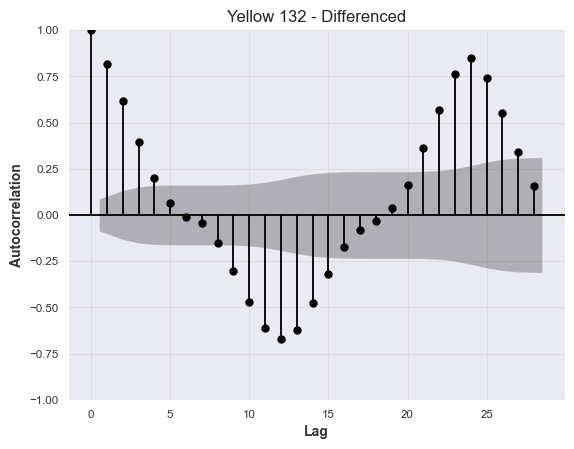

In [85]:
plot_acf(train, title='Yellow 132 - Differenced')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

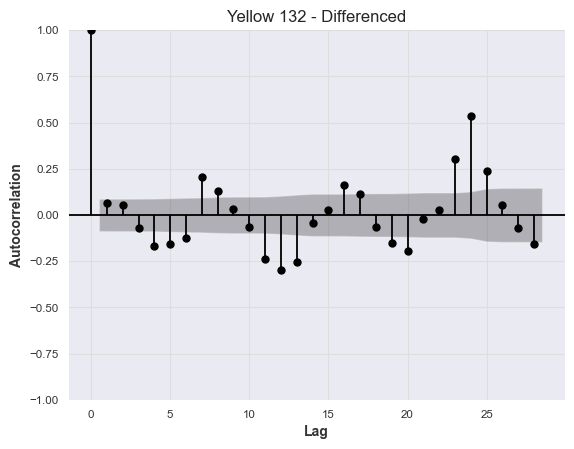

In [86]:
plot_acf(target_diff, title='Yellow 132 - Differenced')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

All methods for determining ACF and PACF values have not shown any sharp cutoff in lag values. This implies that an ARMA model may best model the time series.

We'll use auto-arima to determine the optimal (p,q) values and fit them to the data:

**Using Non-Transformed Data**

In [87]:
# Using Non-Transformed Data
est = pm.auto_arima(
    train,
    stepwise=False, # this goes slower but gets us a more complete search
    max_p=10, max_q=10
)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  505
Model:               SARIMAX(0, 0, 5)   Log Likelihood               -2863.631
Date:                Fri, 01 Mar 2024   AIC                           5741.262
Time:                        09:22:25   BIC                           5770.834
Sample:                    01-01-2023   HQIC                          5752.861
                         - 01-22-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    217.9098     14.861     14.663      0.000     188.783     247.037
ma.L1          0.9267      0.044     21.142      0.000       0.841       1.013
ma.L2          0.9244      0.054     17.278      0.000       0.820       1.029
ma.L3          0.8142      0.063     12.864      0.000       0.690       0.938
ma.L4          0.5975      0.052     11.542      0.000       0.496       0.699
ma.L5          0.3059      0.040      7.569      0.000       0.227       0.385
sigma2      4912.7009    261.607     18.779      0.000    4399.961    5425.441
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                29.26
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.00
Prob(H) (two-sided):                  0.41   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model's best AIC on original data is ARIMA(0, 0, 5).

We'll plot the data against the model's predictions and check the residuals of this automatically selected model to confirm that the model used does not appear to leave any residual behavior that needs to be addressed by the addition of more terms:

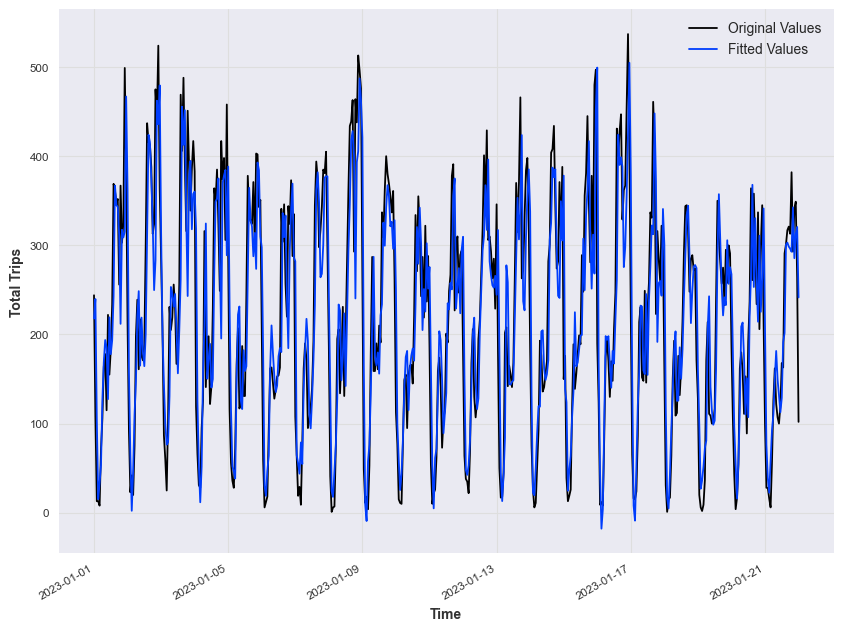

In [88]:
fitted_values = est.fittedvalues()

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(train, label='Original Values')
plt.plot(fitted_values, label='Fitted Values')
plt.xlabel('Time')
plt.ylabel('Total Trips')
plt.legend()
fig.autofmt_xdate()
plt.show()

The model with original data appears to have properly estimated the original values, with an 84% correlation between the original and predicted values. 

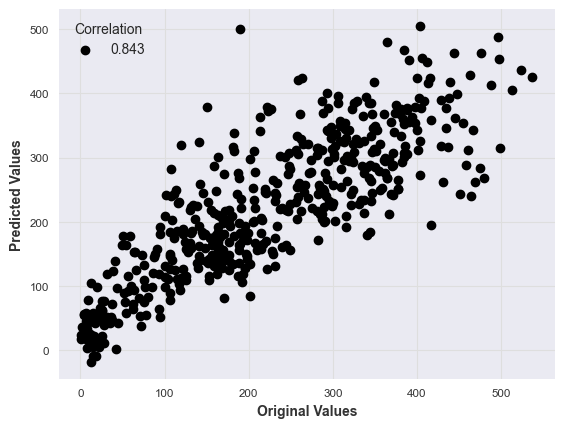

In [89]:
corr, p_value = stats.pearsonr(train, fitted_values)

plt.scatter(train, fitted_values, label=f'{corr:.3f}')
plt.xlabel('Original Values')
plt.ylabel('Predicted Values')
plt.legend(title='Correlation')
plt.show()

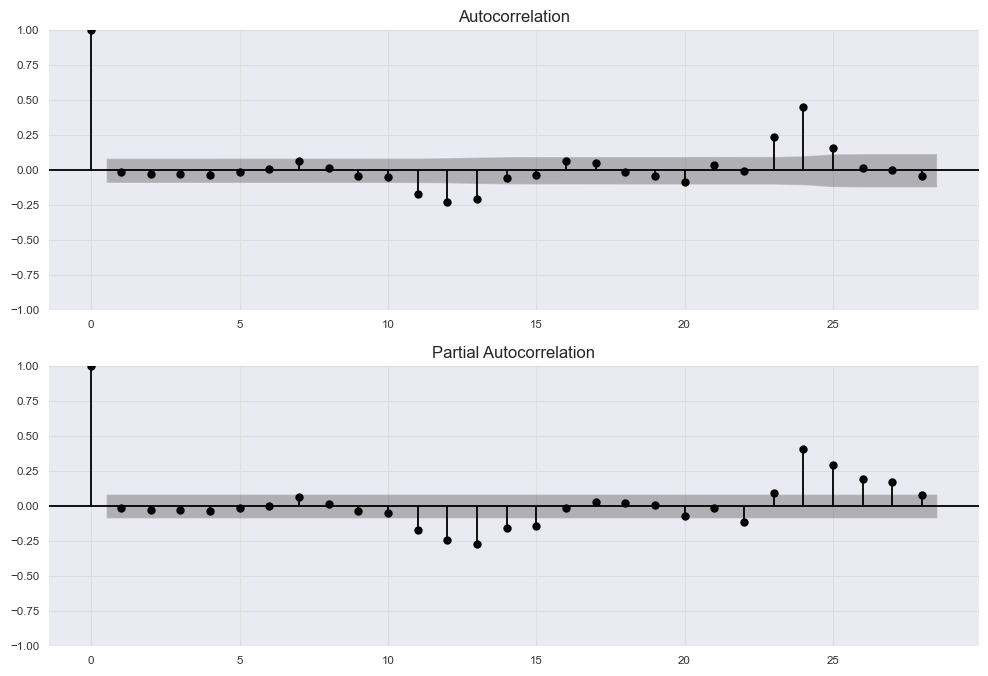

In [90]:
residuals = est.resid()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, ax=ax[1])
plt.show()

In [91]:
est.plot_diagnostics(figsize=(10,8))
plt.show()

In [92]:
lb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_df

lb_stat  lb_pvalue
1   0.118450   0.730722
2   0.400494   0.818529
3   0.706578   0.871656
4   1.246911   0.870316
5   1.326647   0.932166
6   1.348016   0.968944
7   3.795883   0.802965
8   3.898615   0.866153
9   4.618593   0.866210
10  5.823985   0.829828

With ARIMA(5,0,0) on the original data, the model's predictions fit the original data with 83% correlation. The model's residuals also show that it has described the autoregressive behaviour, and Box Test p-values imply that there are no temporal correlations between residual points up to the 10th Lag. 

While this model somewhat describes the data, we have to be concerned about the problem of stationarity as well as the significant autocorrelation coefficients in the residuals after lag 11. We'll attempt to model the differenced data and compare.

**Using Transformed Data**

In [93]:
# Using Transformed Data
est = pm.auto_arima(
    target_diff,
    stepwise=False, # this goes slower but gets us a more complete search
    max_p=10, max_q=10
)
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  505
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -2904.771
Date:                Fri, 01 Mar 2024   AIC                           5823.542
Time:                        09:22:34   BIC                           5853.114
Sample:                    01-01-2023   HQIC                          5835.141
                         - 01-22-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2219      3.626      0.061      0.951      -6.886       7.329
ar.L1          0.0272      0.041      0.672      0.502      -0.052       0.107
ar.L2          0.0536      0.048      1.122      0.262      -0.040       0.147
ar.L3         -0.0605      0.057     -1.069      0.285      -0.171       0.050
ar.L4         -0.1582      0.054     -2.951      0.003      -0.263      -0.053
ar.L5         -0.1407      0.046     -3.064      0.002      -0.231      -0.051
sigma2      5808.5020    329.231     17.643      0.000    5163.221    6453.783
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                23.74
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.33
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model's best AIC on differenced data is ARIMA(5, 0, 0). When we examine the predictions against the differenced data, we find a 24% correlation in values, which is significant given that all trends have been removed from the data and predictions.

In [94]:
fitted_values = est.fittedvalues()

fig, ax = plt.subplots(figsize=(10, 8))
# plt.plot(yellow_132, label='Original Values')
plt.plot(target_diff, label='Differenced Values')
plt.plot(fitted_values, label='Fitted Values')
plt.xlabel('Time')
plt.ylabel('Total Trips')
plt.legend()
fig.autofmt_xdate()
plt.show()

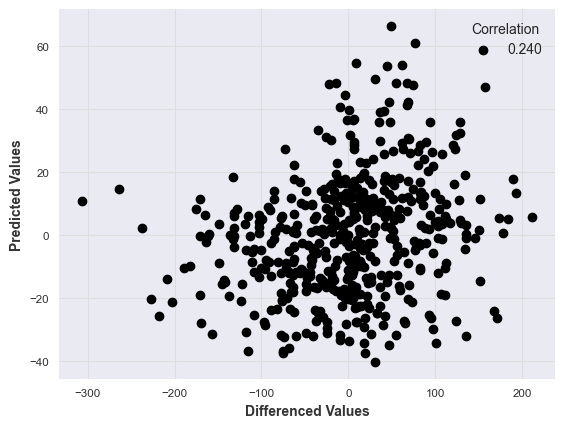

In [95]:
corr, p_value = stats.pearsonr(target_diff, fitted_values)

plt.scatter(target_diff, fitted_values, label=f'{corr:.3f}')
plt.xlabel('Differenced Values')
plt.ylabel('Predicted Values')
plt.legend(title='Correlation')
plt.show()

Let's review the residuals of the model:

Both the ACF Residual Plot and the Ljung Box Test of the Model's residuals imply that there is temporal correlation between residual points. This means that the model does not adequately describe the data.

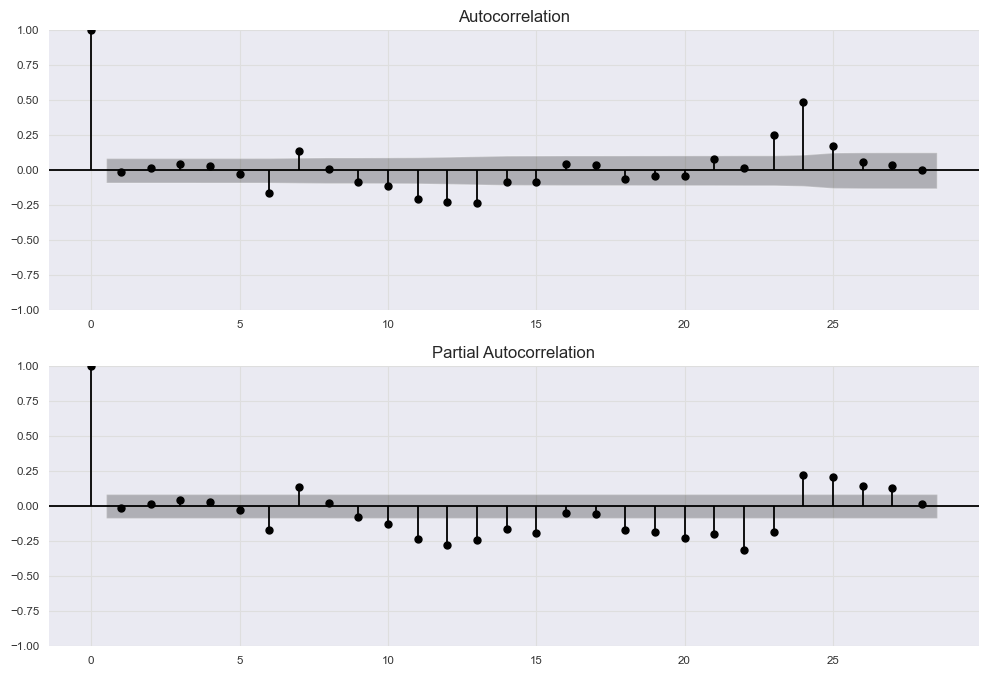

In [96]:
residuals = est.resid()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, ax=ax[1])
plt.show()

In [97]:
est.plot_diagnostics(figsize=(10,8))
plt.show()

In [98]:
lb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_df

lb_stat  lb_pvalue
1    0.103504   0.747665
2    0.209109   0.900726
3    1.087106   0.780188
4    1.490355   0.828348
5    1.808507   0.874956
6   15.816911   0.014771
7   25.836590   0.000539
8   25.915495   0.001086
9   29.521789   0.000529
10  36.250405   0.000076

The transformed model has autocorrelation coefficients in its residuals after lag 5, implying an inadequate model.

In conclusion, the best ARIMA model (ARIMA(0,0,5) on original data) has significant autocorrelations in residuals after lag 10.

Let's attempt Other Models: 

We'll compare our initial ARIMA model with estimations from the following models:
1. Naive Last Observation
2. Naive Seasonal Model
3. Moving Average Model
4. Exponential Smoothing Model
5. Theta Model
6. Fast Fourier Transform Model

We'll also evaluate our ARIMA model and compare evaluation across all models to determine the best statistical time series model. We'll be using the following metric terms:
1. Mean Absolute Error (MAE): measures the average absolute difference between the predicted values and the actual values.
2. Mean Squared Error (MSE): measures the average squared difference between the predicted values and the actual values.
3. Mean Absolute Percentage Error (MAPE): measures the average percentage difference between the predicted values and the actual values, relative to the actual values.
4. Bias: measures the average tendency of the forecast to be higher or lower than the actual values.

In [99]:
pred_df = pd.concat([train, val]).to_frame()
metric_record = []

In [100]:
ts_train = TimeSeries.from_series(train)
ts_val = TimeSeries.from_series(val)
ts_test = TimeSeries.from_series(test)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64

Relevant Functions:

In [101]:
def _remove_nan_union(array_a: np.ndarray,
                      array_b: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns the two inputs arrays where all elements are deleted that have an index that corresponds to
    a NaN value in either of the two input arrays.
    """

    isnan_mask = np.logical_or(np.isnan(array_a), np.isnan(array_b))
    return np.delete(array_a, isnan_mask), np.delete(array_b, isnan_mask)

In [102]:
def forecast_bias(actual_series: Union[TimeSeries, Sequence[TimeSeries], np.ndarray],
                  pred_series: Union[TimeSeries, Sequence[TimeSeries], np.ndarray],
                  intersect: bool = True,
                  *,
                  reduction: Callable[[np.ndarray], float] = np.mean,
                  inter_reduction: Callable[[np.ndarray], Union[float, np.ndarray]] = lambda x: x,
                  n_jobs: int = 1,
                  verbose: bool = False) -> Union[float, np.ndarray]:
    """ Forecast Bias (FB).

    Given a time series of actual values :math:`y_t` and a time series of predicted values :math:`\\hat{y}_t`
    both of length :math:`T`, it is a percentage value computed as

    .. math:: 100 \\cdot \\frac{\\sum_{t=1}^{T}{y_t}
              - \\sum_{t=1}^{T}{\\hat{y}_t}}{\\sum_{t=1}^{T}{y_t}}.

    If any of the series is stochastic (containing several samples), the median sample value is considered.

    Parameters
    ----------
    actual_series
        The `TimeSeries` or `Sequence[TimeSeries]` of actual values.
    pred_series
        The `TimeSeries` or `Sequence[TimeSeries]` of predicted values.
    intersect
        For time series that are overlapping in time without having the same time index, setting `intersect=True`
        will consider the values only over their common time interval (intersection in time).
    reduction
        Function taking as input a `np.ndarray` and returning a scalar value. This function is used to aggregate
        the metrics of different components in case of multivariate `TimeSeries` instances.
    inter_reduction
        Function taking as input a `np.ndarray` and returning either a scalar value or a `np.ndarray`.
        This function can be used to aggregate the metrics of different series in case the metric is evaluated on a
        `Sequence[TimeSeries]`. Defaults to the identity function, which returns the pairwise metrics for each pair
        of `TimeSeries` received in input. Example: `inter_reduction=np.mean`, will return the average of the pairwise
        metrics.
    n_jobs
        The number of jobs to run in parallel. Parallel jobs are created only when a `Sequence[TimeSeries]` is
        passed as input, parallelising operations regarding different `TimeSeries`. Defaults to `1`
        (sequential). Setting the parameter to `-1` means using all the available processors.
    verbose
        Optionally, whether to print operations progress

    Raises
    ------
    ValueError
        If :math:`\\sum_{t=1}^{T}{y_t} = 0`.

    Returns
    -------
    float
        The Forecast Bias (OPE)
    """
    assert type(actual_series) is type(pred_series), "actual_series and pred_series should be of same type."
    if isinstance(actual_series, np.ndarray):
        y_true, y_pred = actual_series, pred_series
    else:
        y_true, y_pred = _get_values_or_raise(actual_series, pred_series, intersect)
    y_true, y_pred = _remove_nan_union(y_true, y_pred)
    y_true_sum, y_pred_sum = np.sum(y_true), np.sum(y_pred)
    # raise_if_not(y_true_sum > 0, 'The series of actual value cannot sum to zero when computing OPE.', logger)
    return ((y_true_sum - y_pred_sum) / y_true_sum) * 100.


In [103]:
def forecast_bias_aggregate(actuals, predictions):
    return 100*(np.nansum(predictions)-np.nansum(actuals))/np.nansum(actuals)

def eval_model(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    model.fit(ts_train)
    y_pred = model.predict(len(ts_test))
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "Forecast Bias": forecast_bias(actual_series = ts_test, pred_series = y_pred),
        "MAPE": mape(actual_series = ts_test, pred_series = y_pred)
    }

def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

In [104]:
def plot_forecast(
        pred_df, plot_title, forecast_columns, forecast_display_names=None
):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = plt.cm.Dark2(np.linspace(0, 1, len(forecast_columns) - 1))
    
    fig, ax = plt.subplots()
    ax.plot(pred_df[mask].index, pred_df[mask].total_trips, color='blue', label='Total Trips')

    for i, col in enumerate(forecast_columns):
        if col != 'total_trips':
            ax.plot(
                pred_df[mask].index, pred_df.loc[mask, col], 
                linestyle='--', 
                # color=colors[i+1], 
                label=forecast_display_names[i])

    ax.legend()
    plt.xlabel('Date')
    plt.ylabel('Total Trips')
    plt.title(plot_title)
    plt.grid(True)
    fig.autofmt_xdate()
    plt.show()

In [105]:
import time
import humanize

class LogTime:
    def __init__(self, verbose=True, **humanize_kwargs):
        if "minimum_unit" not in humanize_kwargs.keys():
            humanize_kwargs["minimum_unit"] = 'microseconds'
        self.humanize_kwargs = humanize_kwargs
        self.verbose = verbose

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        """
        Exceptions are captured in *args, we’ll handle none, since failing can be timed anyway
        """
        self.elapsed = time.time() - self.start
        self.elapsed_str = humanize.precisedelta(self.elapsed, **self.humanize_kwargs)
        if self.verbose:
            print(f"Time Elapsed: {self.elapsed_str}")


**Naive Last Value**

In [106]:
name = "Naive Last Value"
naive_model = NaiveSeasonal(K=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "naive_last_value")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


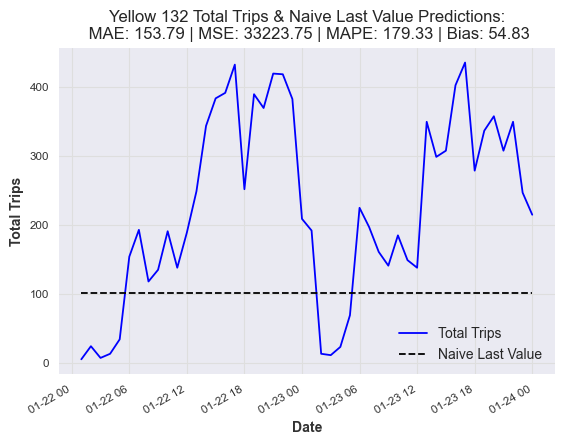

In [107]:
plot_forecast(
    pred_df,
    plot_title=f"Yellow 132 Total Trips & Naive Last Value Predictions:\n MAE: {metrics['MAE']:.2f} | MSE: {metrics['MSE']:.2f} | MAPE: {metrics['MAPE']:.2f} | Bias: {metrics['Forecast Bias']:.2f}",
    forecast_columns=["naive_last_value"], 
    forecast_display_names=['Naive Last Value'])


**Naive Seasonal**

In [108]:
name = "Seasonal Naive Forecast"
naive_model = NaiveSeasonal(K=24*7)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "snaive_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


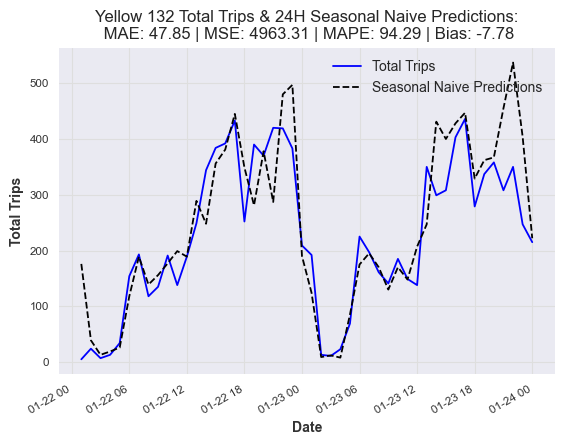

In [109]:
plot_forecast(
    pred_df,
    plot_title=f"Yellow 132 Total Trips & 24H Seasonal Naive Predictions:\n MAE: {metrics['MAE']:.2f} | MSE: {metrics['MSE']:.2f} | MAPE: {metrics['MAPE']:.2f} | Bias: {metrics['Forecast Bias']:.2f}",
    forecast_columns=["snaive_predictions"],
    forecast_display_names=['Seasonal Naive Predictions'])

**Moving Average**

In [110]:
name = "Moving Average Forecast"
naive_model = NaiveMovingAverage(input_chunk_length=24)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "moving_average_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [111]:
plot_forecast(
    pred_df,
    plot_title=f"Yellow 132 Total Trips & 6H Moving Average Predictions:\n MAE: {metrics['MAE']:.2f} | MSE: {metrics['MSE']:.2f} | MAPE: {metrics['MAPE']:.2f} | Bias: {metrics['Forecast Bias']:.2f}",
    forecast_columns=["moving_average_predictions"],
    forecast_display_names=['Moving Average Predictions'])

**Exponential Smoothing**

In [112]:
name = "Exponential Smoothing"
# Suppress FutureWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    ets_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=True, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24*7, random_state=42)
    with LogTime() as timer:
        y_pred, metrics = eval_model(ets_model, ts_train, ts_val, name=name)
    metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "ets_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


In [113]:
plot_forecast(
    pred_df,
    plot_title=f"Yellow 132 Total Trips & Exponential Smoothing Predictions:\n MAE: {metrics['MAE']:.2f} | MSE: {metrics['MSE']:.2f} | MAPE: {metrics['MAPE']:.2f} | Bias: {metrics['Forecast Bias']:.2f}",
    forecast_columns=["ets_predictions"],
    forecast_display_names=['Exponential Smoothing Predictions'])

**ARIMA**

In [114]:
name = "ARIMA"
arima_model = AutoARIMA(max_p=10, max_q=10, m=24, seasonal=True)
with LogTime() as timer:
    y_pred, metrics = eval_model(arima_model, ts_train, ts_val,  name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "arima_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 22 minutes and 55 seconds


In [115]:
amd = arima_model.fit(ts_train)
amd.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  505
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 24)   Log Likelihood               -2688.413
Date:                              Fri, 01 Mar 2024   AIC                           5388.825
Time:                                      10:06:26   BIC                           5414.173
Sample:                                           0   HQIC                          5398.767
                                              - 505                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3804      0.589      2.345      0.019       0.227       2.534
ar.L1          0.3679      0.035     10.426      0.000       0.299       0.437
ar.L2          0.1986      0.040      5.005      0.000       0.121       0.276
ar.S.L24       0.9848      0.005    183.808      0.000       0.974       0.995
ma.S.L24      -0.7487      0.039    -19.352      0.000      -0.825      -0.673
sigma2      2269.3050    123.241     18.414      0.000    2027.757    2510.853
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                37.97
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.44
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

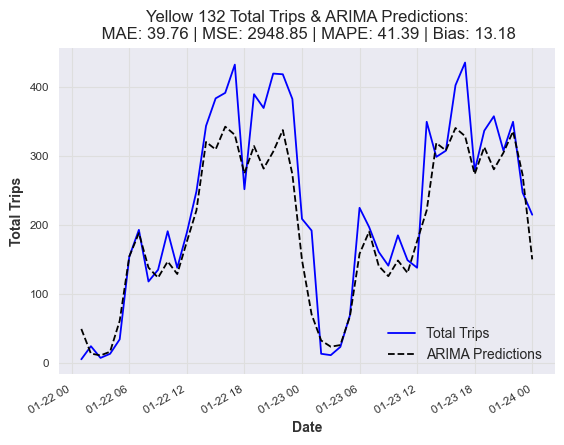

In [116]:
plot_forecast(
    pred_df,
    plot_title=f"Yellow 132 Total Trips & ARIMA Predictions:\n MAE: {metrics['MAE']:.2f} | MSE: {metrics['MSE']:.2f} | MAPE: {metrics['MAPE']:.2f} | Bias: {metrics['Forecast Bias']:.2f}",
    forecast_columns=["arima_predictions"],
    forecast_display_names=['ARIMA Predictions'])

**Theta**

In [117]:
name = "Theta"
theta_model = Theta(theta=3, seasonality_period=24*7, season_mode=SeasonalityMode.ADDITIVE)
with LogTime() as timer:
    y_pred, metrics = eval_model(theta_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "theta_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


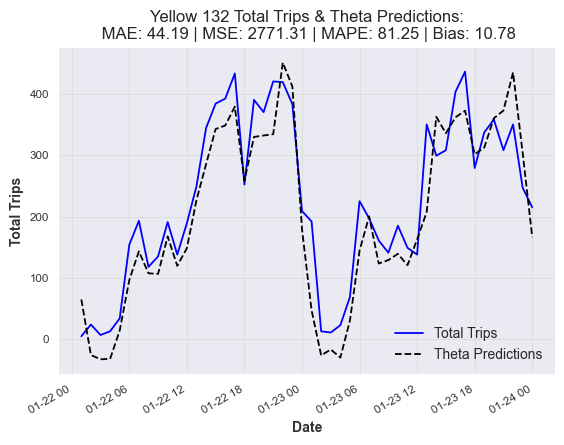

In [118]:
plot_forecast(
    pred_df,
    plot_title=f"Yellow 132 Total Trips & Theta Predictions:\n MAE: {metrics['MAE']:.2f} | MSE: {metrics['MSE']:.2f} | MAPE: {metrics['MAPE']:.2f} | Bias: {metrics['Forecast Bias']:.2f}",
    forecast_columns=["theta_predictions"],
    forecast_display_names=['Theta Predictions'])

**Fast Fourier Transform**

In [119]:
name = "FFT"
fft_model = FFT(nr_freqs_to_keep=48, trend="poly", trend_poly_degree=2)
with LogTime() as timer:
    y_pred, metrics = eval_model(fft_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "fft_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


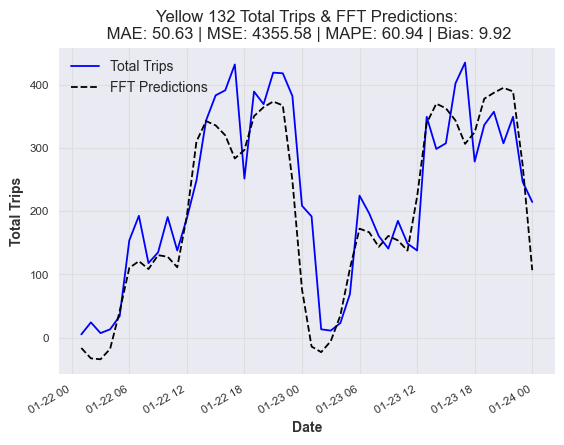

In [120]:
plot_forecast(
    pred_df,
    plot_title=f"Yellow 132 Total Trips & FFT Predictions:\n MAE: {metrics['MAE']:.2f} | MSE: {metrics['MSE']:.2f} | MAPE: {metrics['MAPE']:.2f} | Bias: {metrics['Forecast Bias']:.2f}",
    forecast_columns=["fft_predictions"],
    forecast_display_names=['FFT Predictions'])

Metrics Summary:

In [121]:
metric_styled = pd.DataFrame(metric_record).style.format(
    {"MAE": "{:.3f}", "MSE": "{:.3f}", "MAPE": "{:.2f}%",
     "Forecast Bias": "{:.2f}%", "MASE":"{:.3f}"}
).highlight_min(color='lightgreen', subset=["MAE","MSE","MAPE","Time Elapsed"])
display(metric_styled)

Conclusion:

By metric, the SARIMA model SARIMA(2, 0, 0)(1, 0, 1) is the best model. However, it is also the slowest model given that we used AutoARIMA to arrive at our parameters. Theta, Exponential Smoothing and FFT have values around the same range and are much faster in runtime. 